In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

c:\Users\Scent\anaconda3\envs\CENT000\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 指定されたプロシージャが見つかりません。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

root = os.path.join(onedrive_path, 'CODES', 'samples', 'cifar10_data')

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


cifar10_train = datasets.CIFAR10(root=root, download=True, train=True, transform=transform)
cifar10_test = datasets.CIFAR10(root=root, download=True, train=False, transform=transform)

batch_size = 100
train_dataloader = DataLoader(cifar10_train, batch_size, shuffle=True)
test_dataloader = DataLoader(cifar10_test, batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

GPU name: NVIDIA GeForce GTX 1660
Using device: cuda


In [4]:
def split_into_kernels(image, kernel_size):
    """
    画像を kernel_size x kernel_size のパッチに分割
    返り値のサイズ: (b, n_patches, c, kernel_size, kernel_size)
    """
    b, c, h, w = image.shape
    assert (h % kernel_size == 0) and (w % kernel_size == 0), "Image size must be divisible by kernel size"
    patches = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    patches = patches.contiguous().view(b, c, -1, kernel_size, kernel_size)
    patches = patches.permute(0, 2, 1, 3, 4)
    return patches

In [5]:
class Encoder(nn.Module):
    def __init__(self, kernel_size, leverage, channels):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage

        # 入力次元: c * (k*k)
        kernel_in = (kernel_size ** 2) * channels
        self.kernel_in = kernel_in
        # 出力次元: kernel_in / leverage
        self.output_dim = int(kernel_in / leverage)

        # ランダムな位相の複素行列 B を作成
        phase = torch.rand(self.output_dim, kernel_in) * 2 * np.pi - np.pi
        modulus = torch.ones(self.output_dim, kernel_in)
        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)

        
        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False

        self.alpha = torch.rand(kernel_in) * 0.5 + 0.5  #<<<<<<<<<<<<<<<
        self.alpha = self.alpha.detach().to(device)
        self.alpha.requires_grad = False

    def forward(self, x):
        """
        xの形状: (b, n_patches, c, k, k)
        """
        b, n_patches, c, kh, kw = x.shape
        
        x = x.reshape(b * n_patches, c * kh * kw)
        x = torch.exp(1j * self.alpha * x) 
        x = x.T 
        x = torch.matmul(self.B, x)
        x = x.T
        x = torch.abs(x) ** 2  
        return x , n_patches

In [6]:
class CNN(nn.Module):
    def __init__(self, in_channels,n_patches):
        super(CNN, self).__init__()
        side = int(np.sqrt(n_patches))
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * side//4 * side//4, 256)
        self.fc2 = nn.Linear(256, 10)

        self.func = nn.ReLU()

    def forward(self, x):
        """
        xの形状: (b, in_channels, side, side)
        """
        # conv1 → ReLU → pool
        x = self.pool(self.func(self.conv1(x)))
        # conv2 → ReLU → pool
        x = self.pool(self.func(self.conv2(x)))
        # フラット化
        x = x.reshape(x.size(0), -1)
        x = self.func(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
class EncoderClassifier(nn.Module):
    def __init__(self, img_size, channels, kernel_size, leverage):
        super(EncoderClassifier, self).__init__()
        self.img_size = img_size
        self.channels = channels
        self.kernel_size = kernel_size
        self.leverage = leverage

        kernel_in = channels * kernel_size ** 2
        feat_dim = int(kernel_in / leverage)
        n_patches = (img_size // kernel_size) * (img_size // kernel_size)

        self.split = split_into_kernels
        self.encoder = Encoder(kernel_size, leverage, channels)
        self.bn = nn.BatchNorm2d(feat_dim)  # CNNのためにBatchNorm2dに変更
        self.classifier = CNN(feat_dim,n_patches)  # CNNの入力チャネル数をfeat_dimに変更

    def forward(self, x):
        b = x.size(0)
        x = x.view(b, self.channels, self.img_size, self.img_size)
        x = self.split(x, self.kernel_size)
        x, n_patches = self.encoder(x)
        x = x.view(b, n_patches, -1)
        side = int(np.sqrt(n_patches))
        x = x.view(b, side, side, -1).permute(0, 3, 1, 2) 
        x = self.bn(x)
        x = self.classifier(x)
        return x

1:2 1th Epoch: 19/20

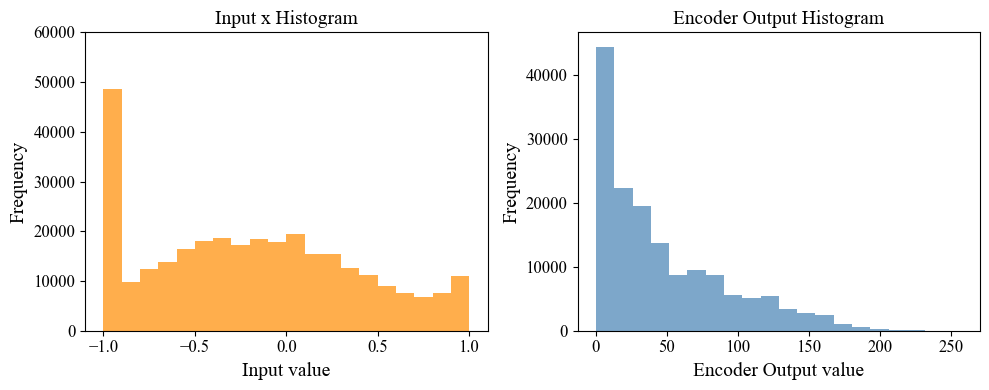

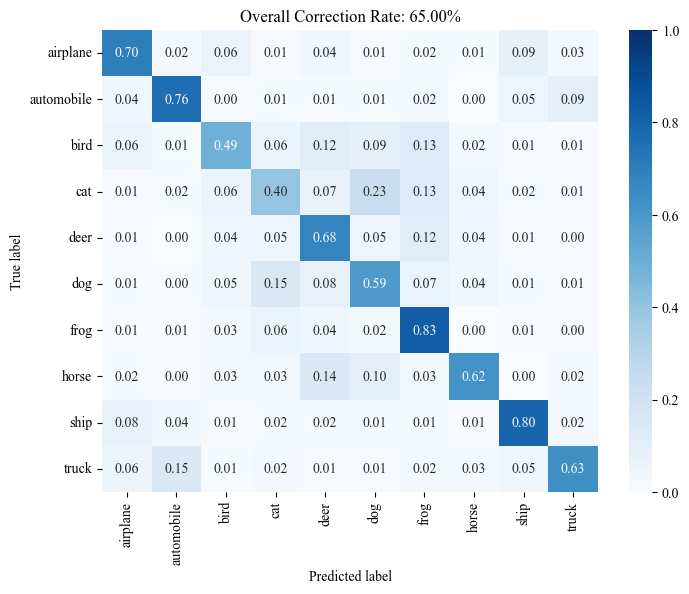

1:2 2th Epoch: 19/20

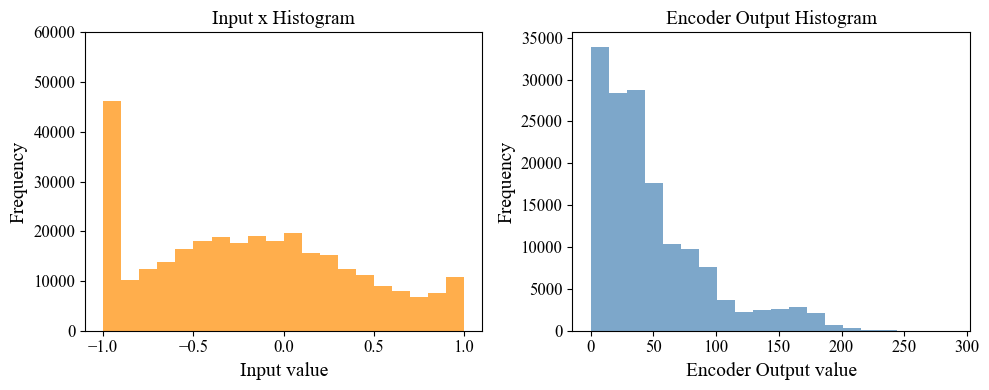

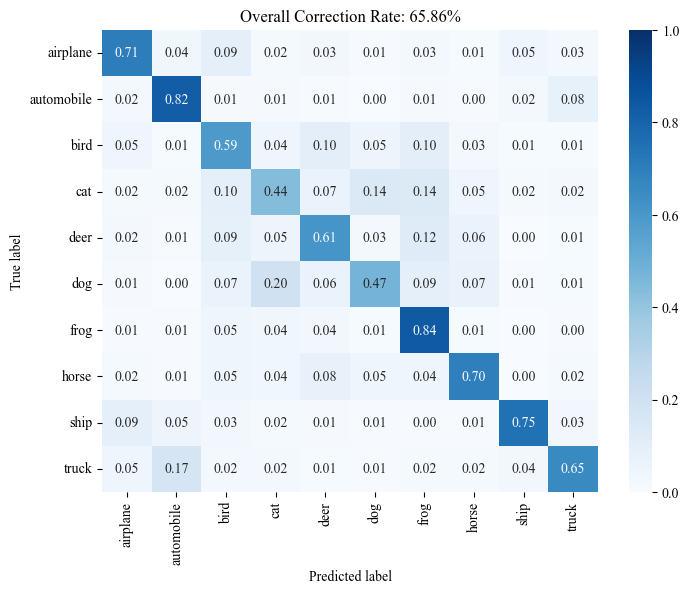

1:2 3th Epoch: 19/20

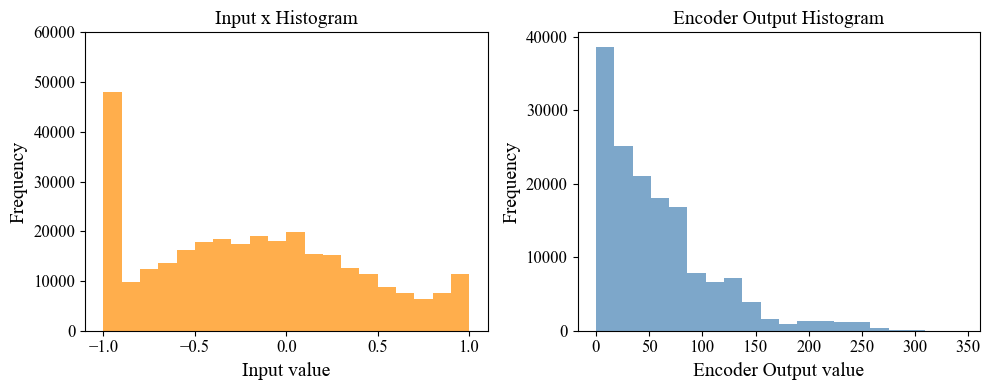

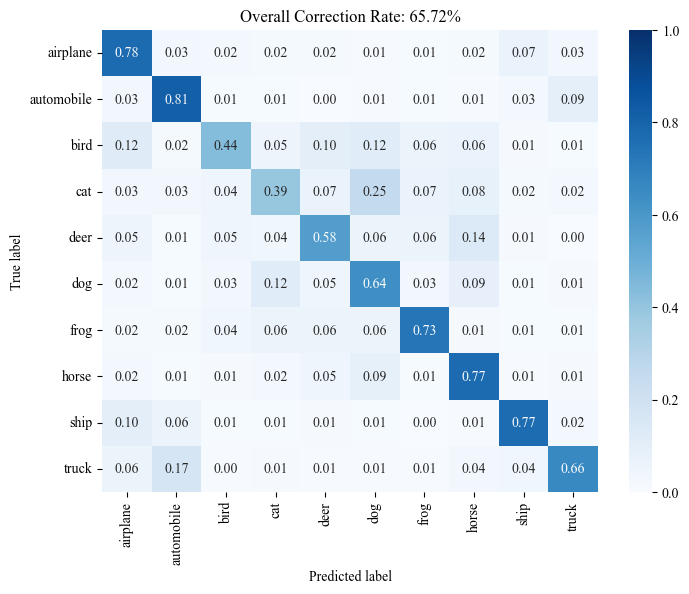

1:2 4th Epoch: 19/20

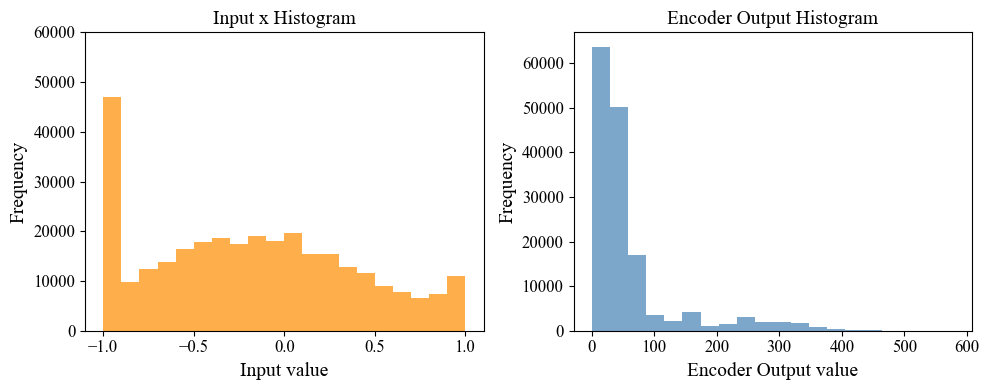

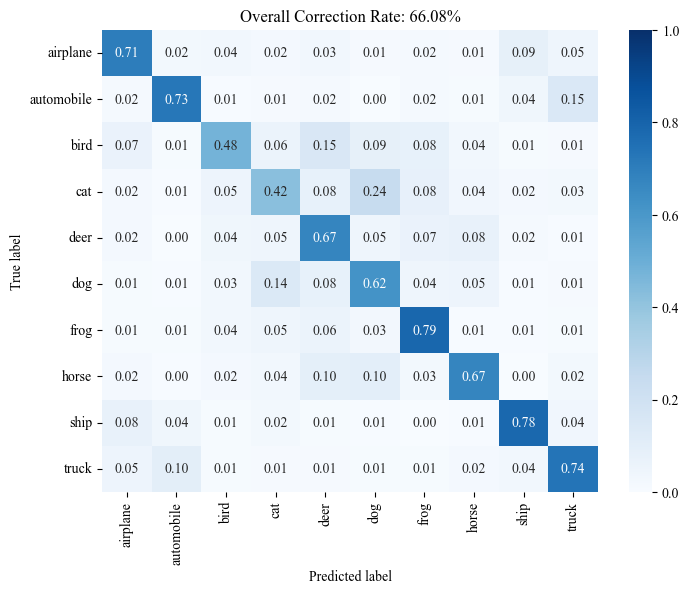

1:2 5th Epoch: 19/20

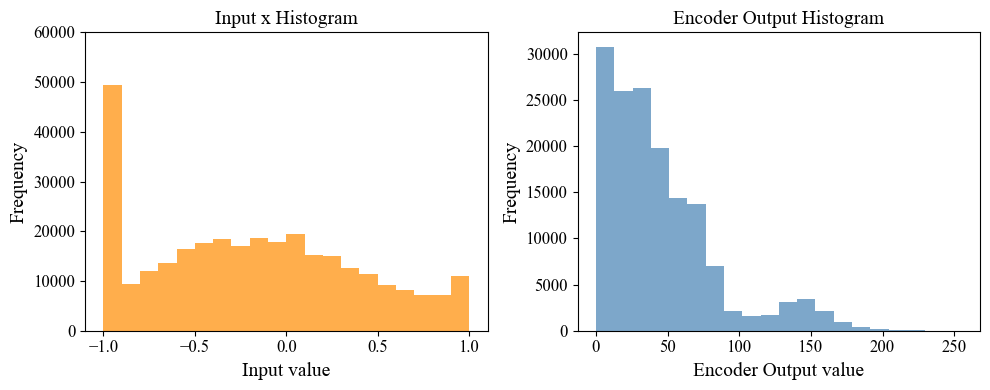

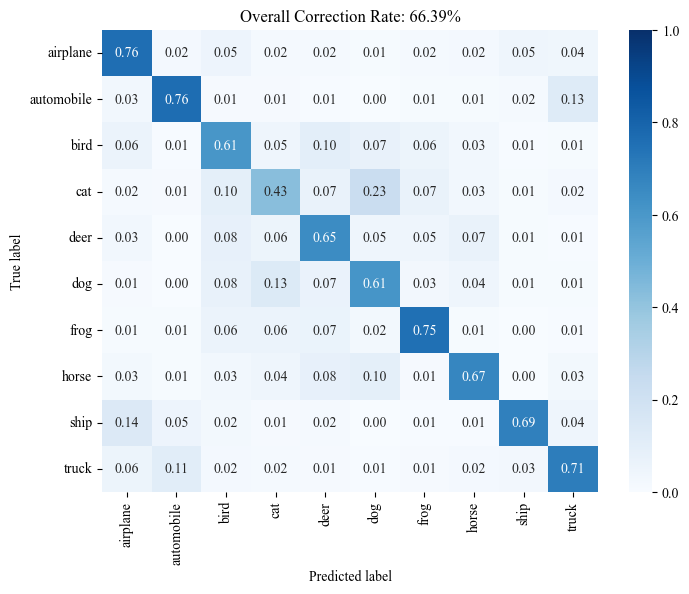

           Average  Best ID       Best  Worst ID      Worst
0   ACC  65.810000        5  66.390000         1  65.000000
1  LOSS   0.970911        4   0.957044         1   0.984614


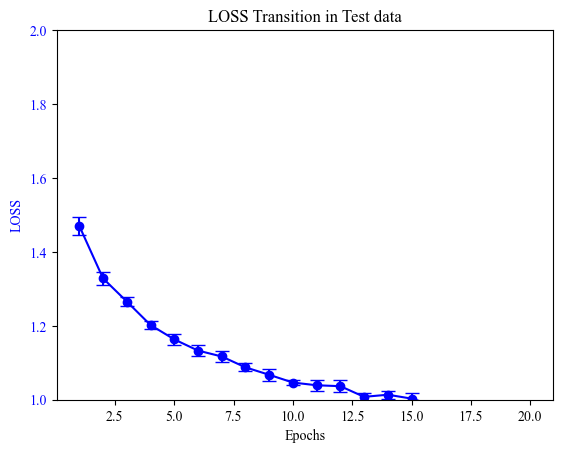

1:4 1th Epoch: 19/20

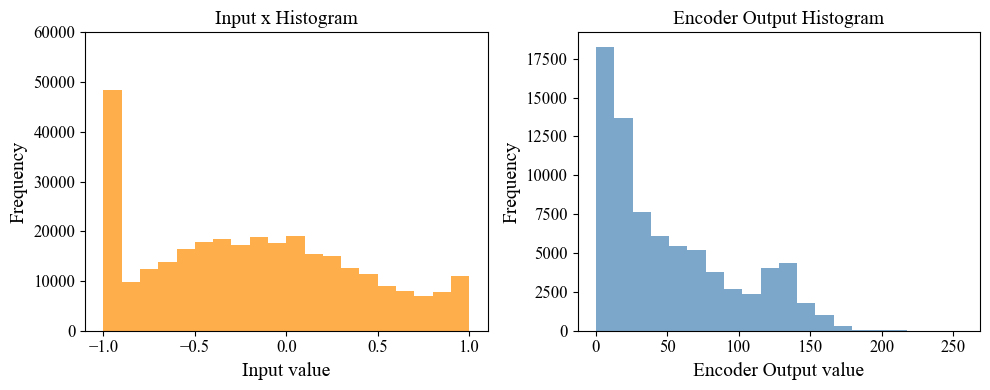

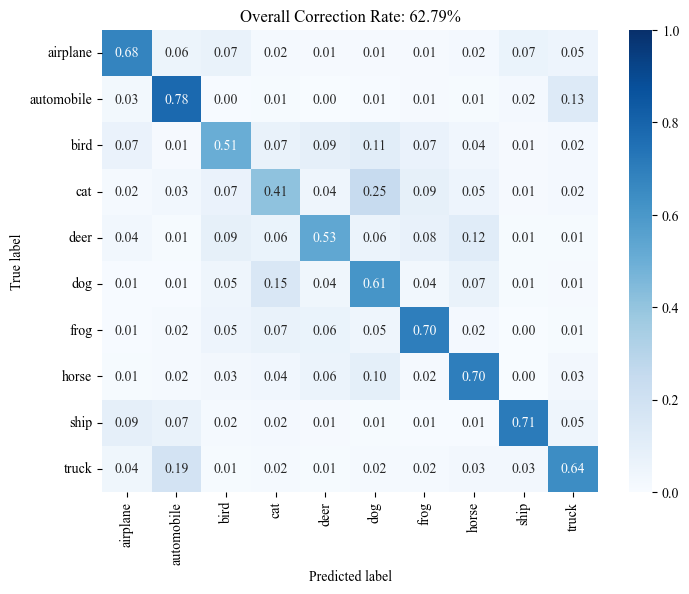

1:4 2th Epoch: 19/20

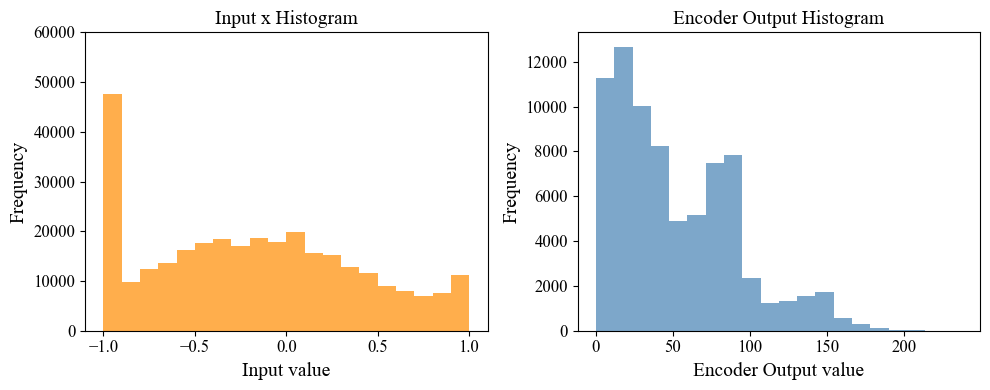

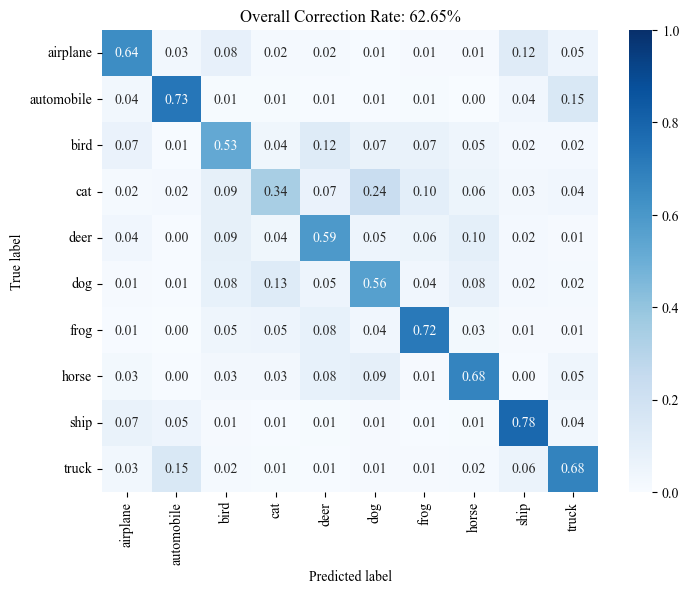

1:4 3th Epoch: 19/20

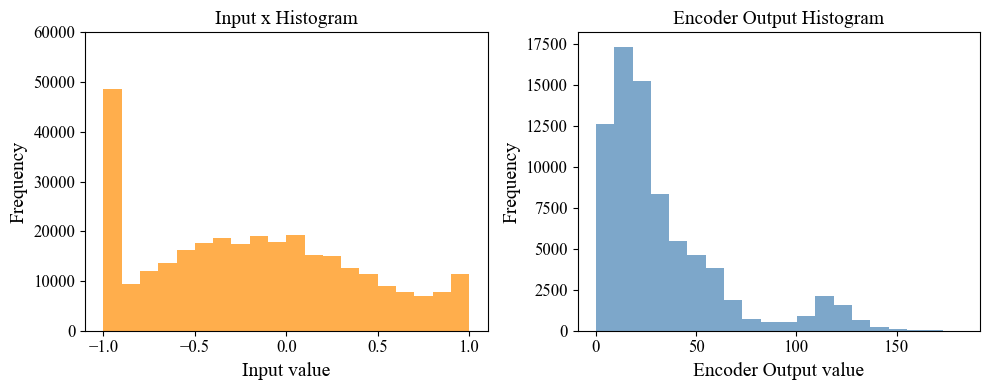

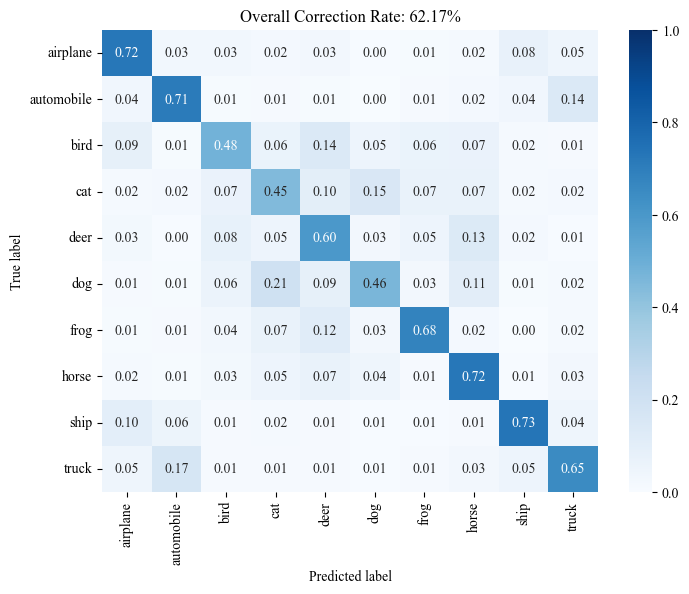

1:4 4th Epoch: 19/20

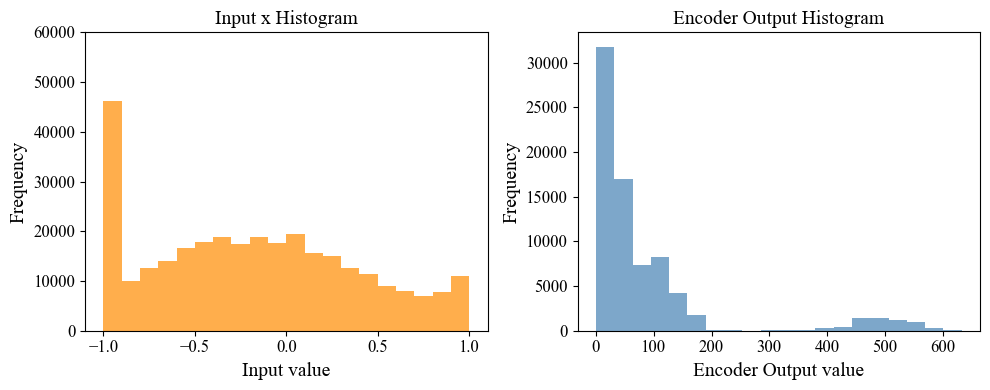

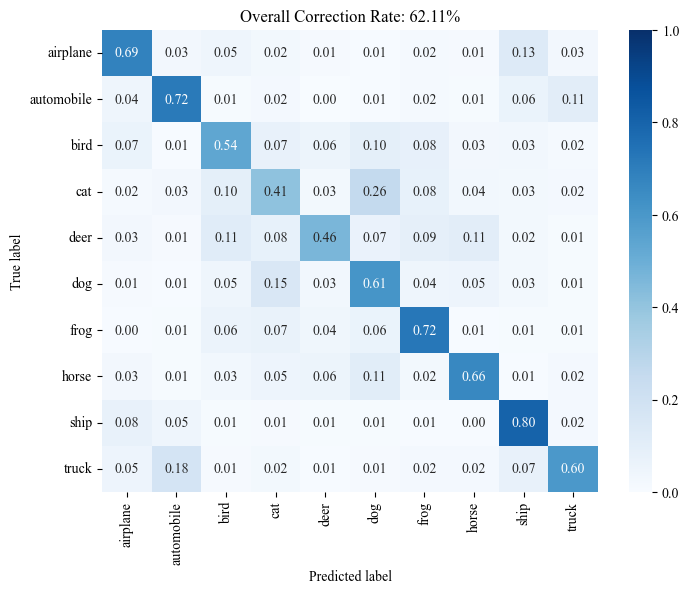

1:4 5th Epoch: 19/20

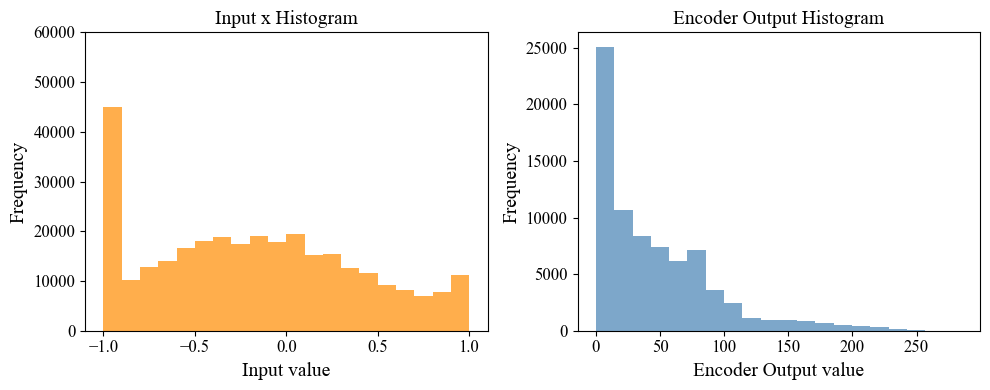

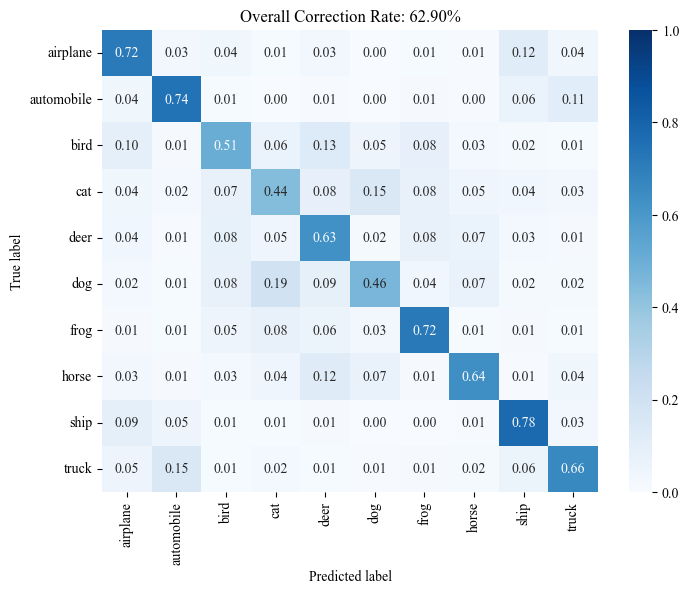

           Average  Best ID       Best  Worst ID      Worst
0   ACC  62.524000        5  62.900000         4  62.110000
1  LOSS   1.056126        5   1.037296         3   1.075532


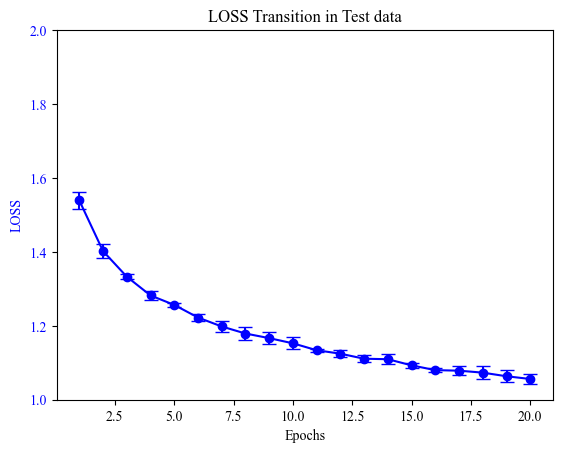

1:6 1th Epoch: 19/20

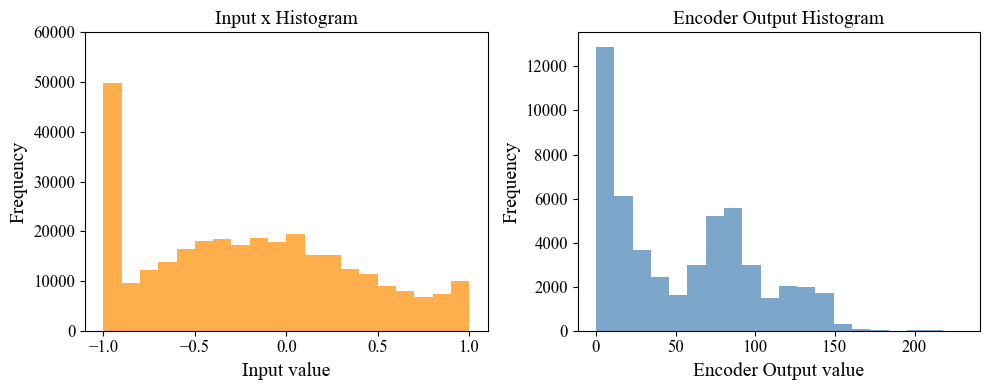

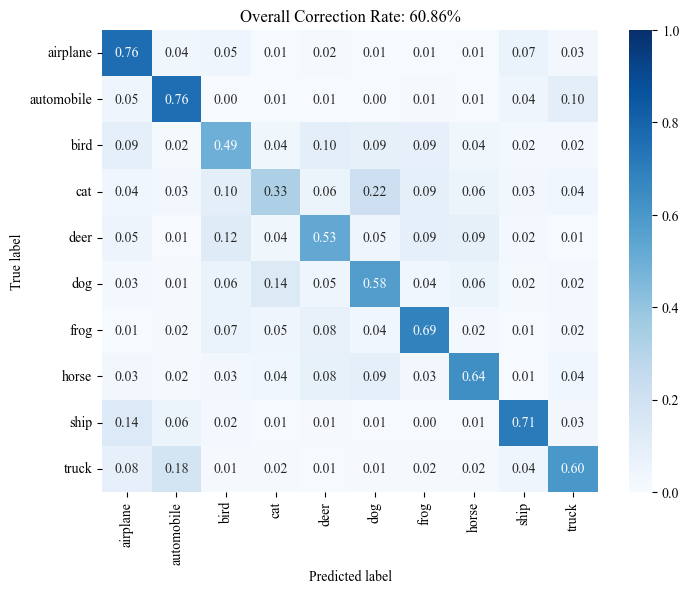

1:6 2th Epoch: 19/20

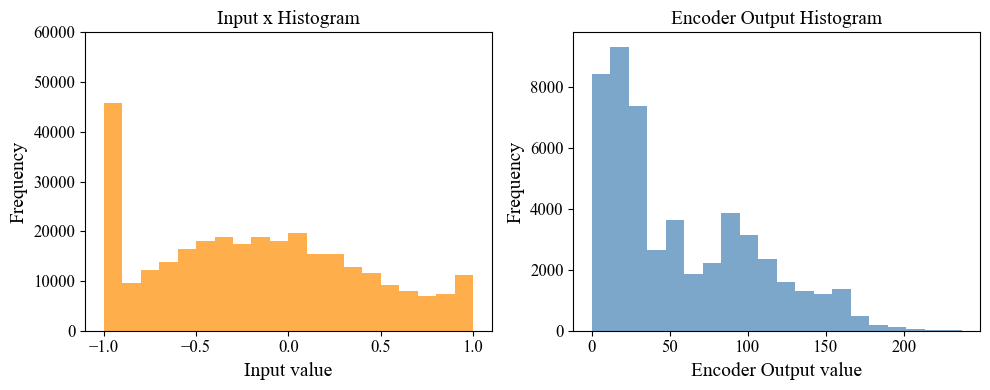

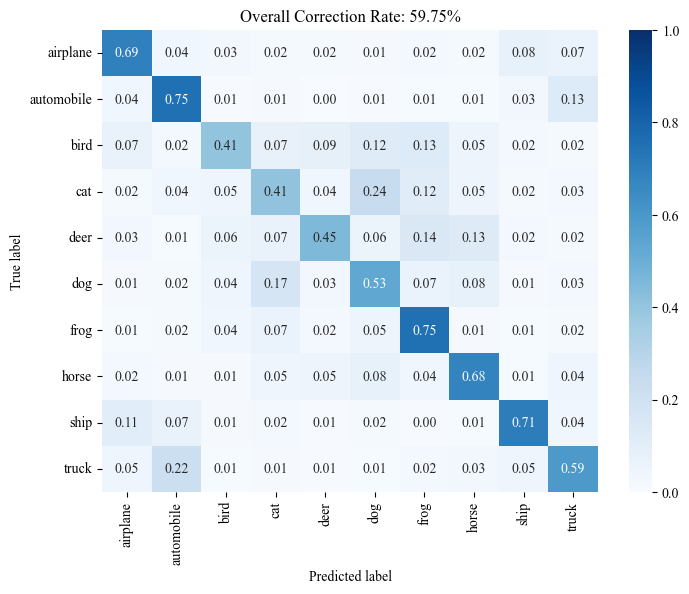

1:6 3th Epoch: 19/20

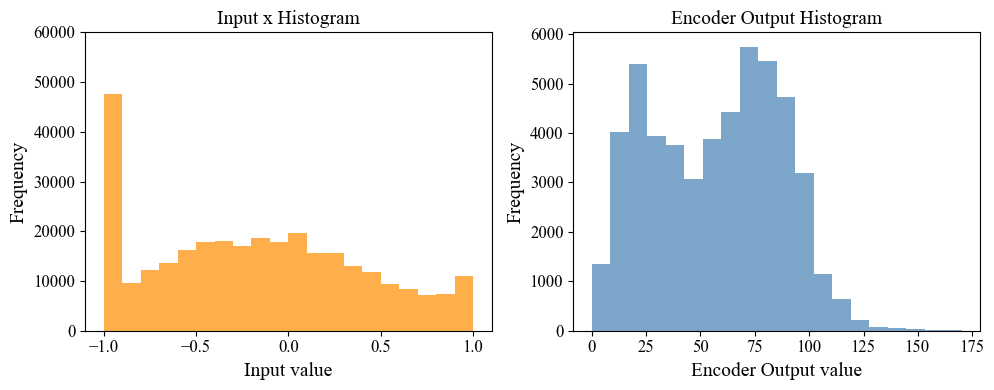

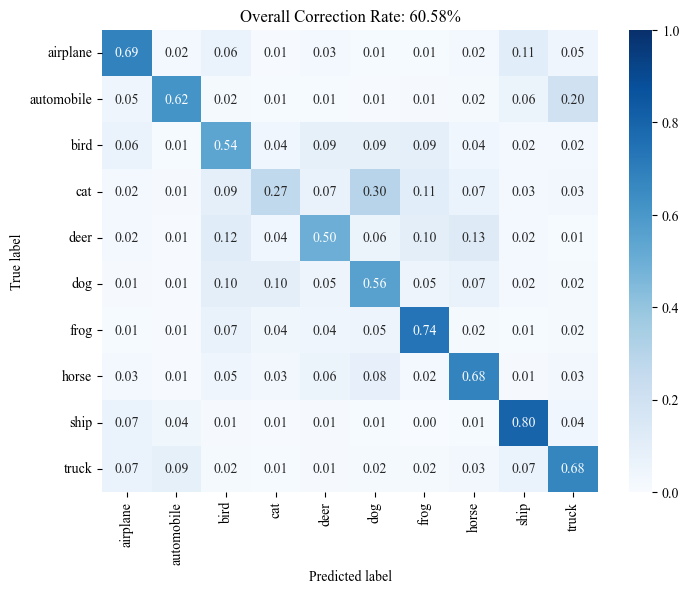

1:6 4th Epoch: 19/20

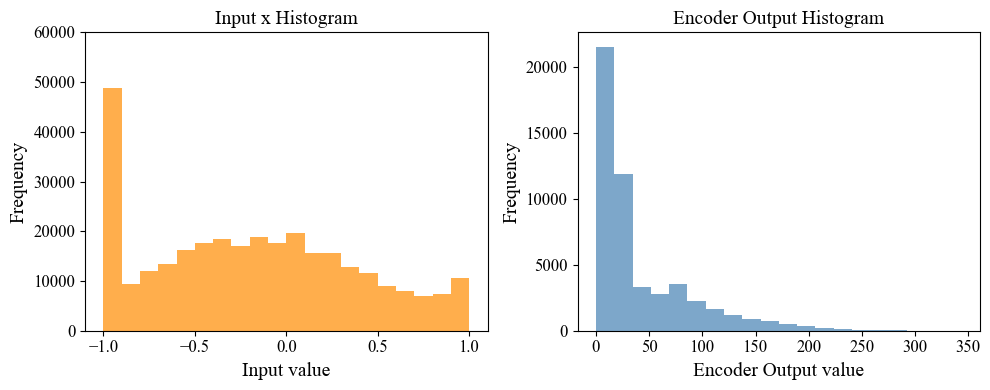

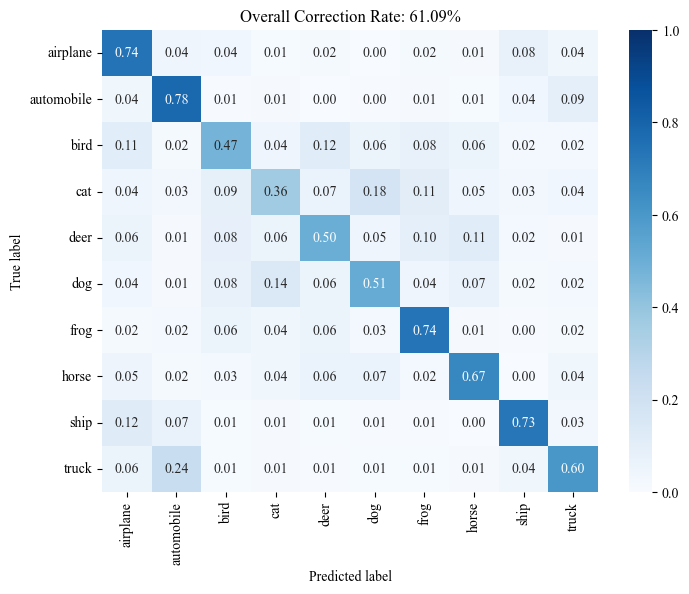

1:6 5th Epoch: 19/20

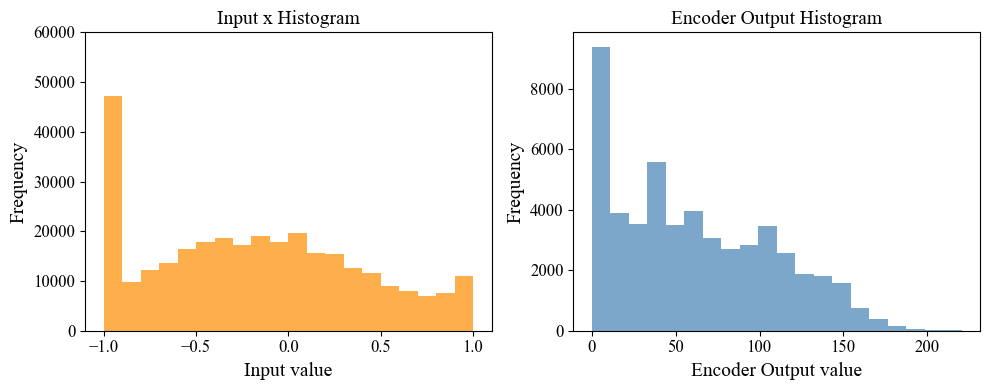

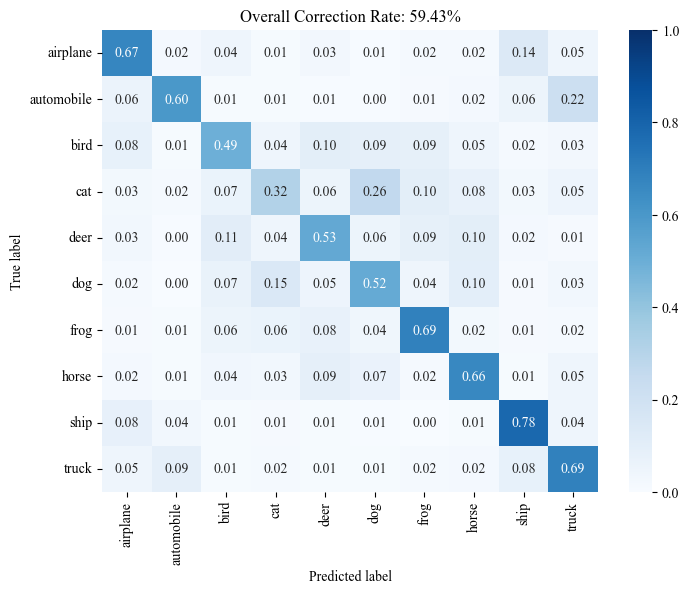

           Average  Best ID       Best  Worst ID      Worst
0   ACC  60.342000        4  61.090000         5  59.430000
1  LOSS   1.121147        4   1.109383         5   1.149001


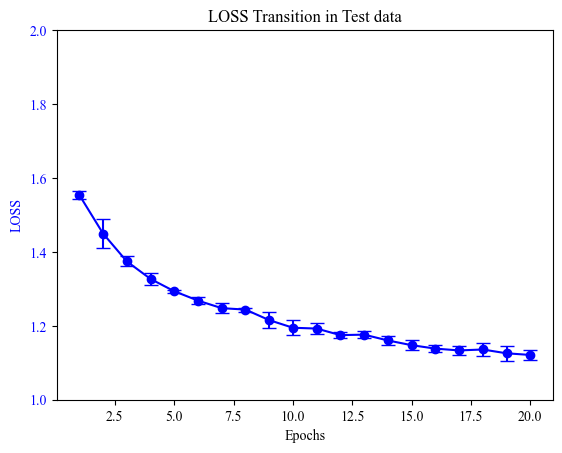

1:8 1th Epoch: 19/20

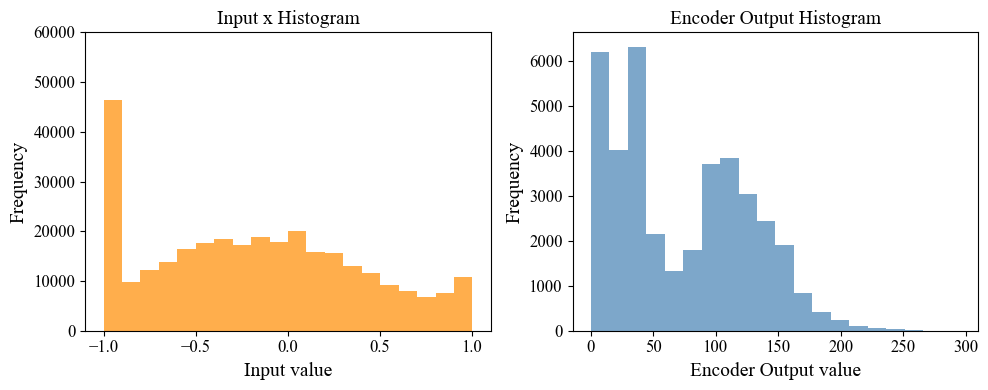

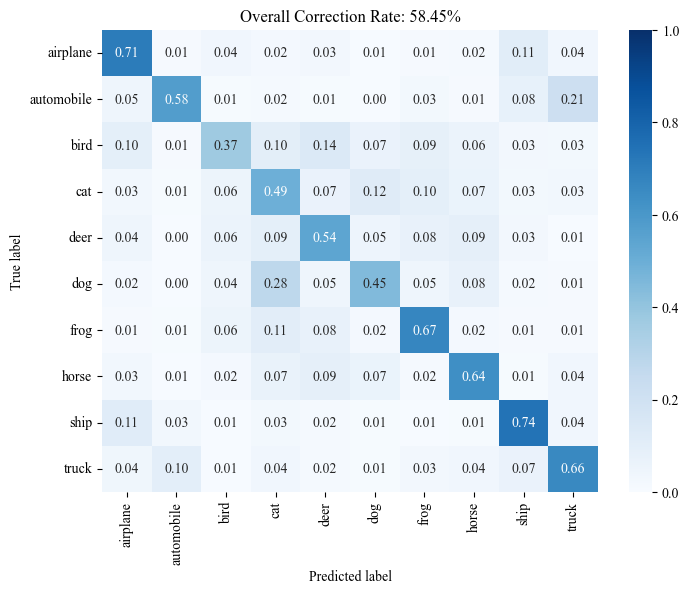

1:8 2th Epoch: 19/20

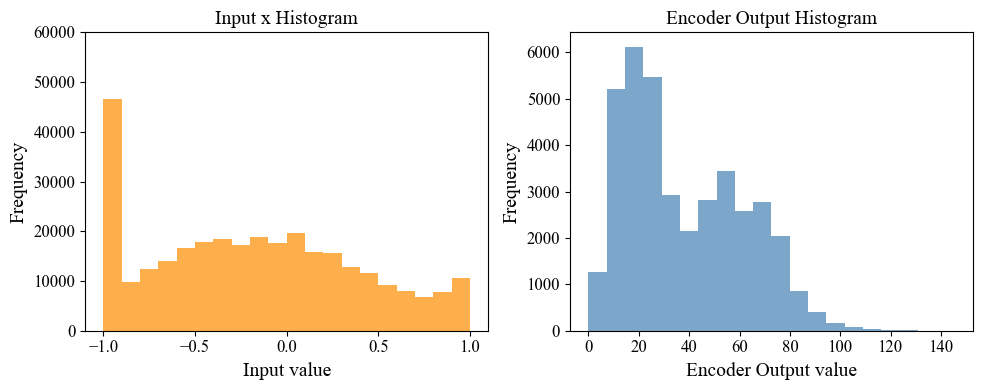

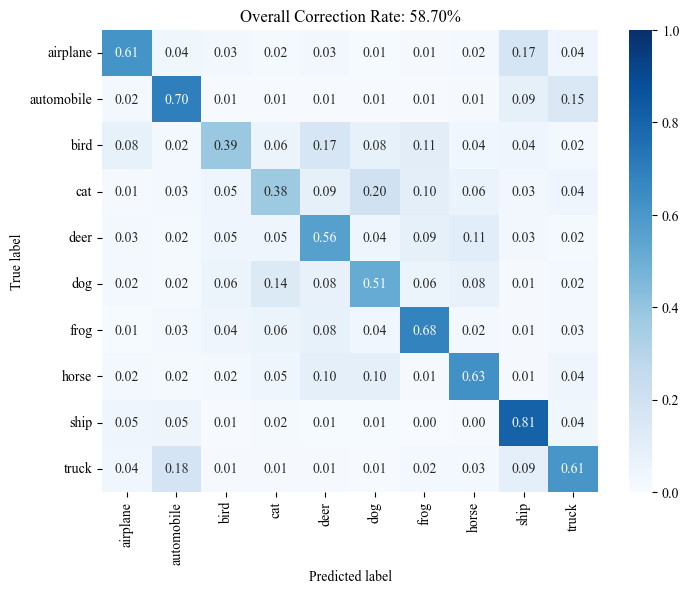

1:8 3th Epoch: 19/20

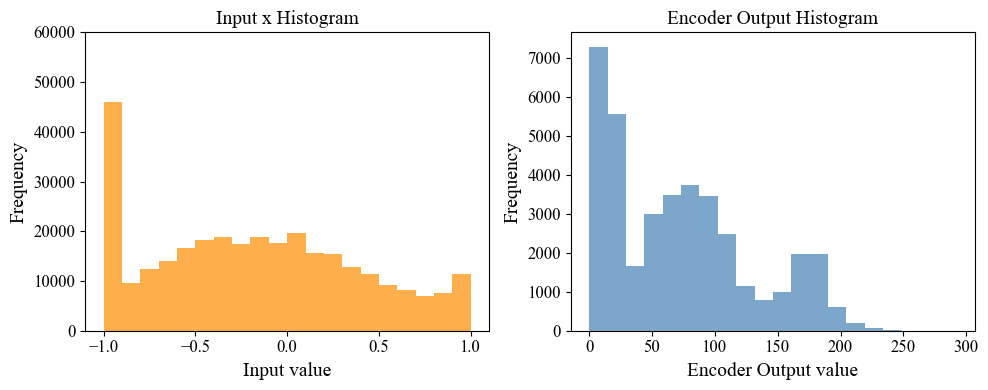

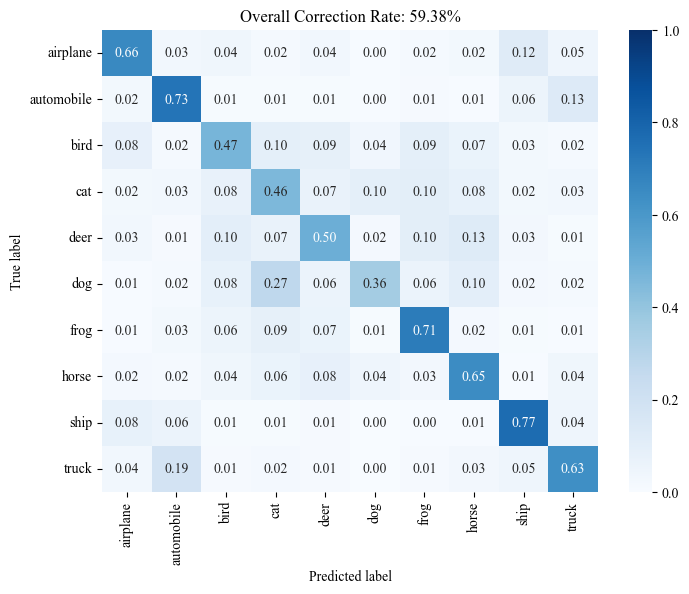

1:8 4th Epoch: 19/20

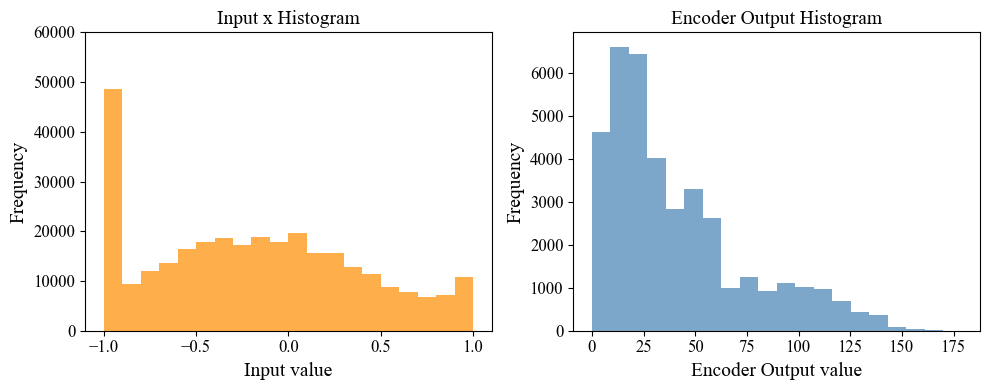

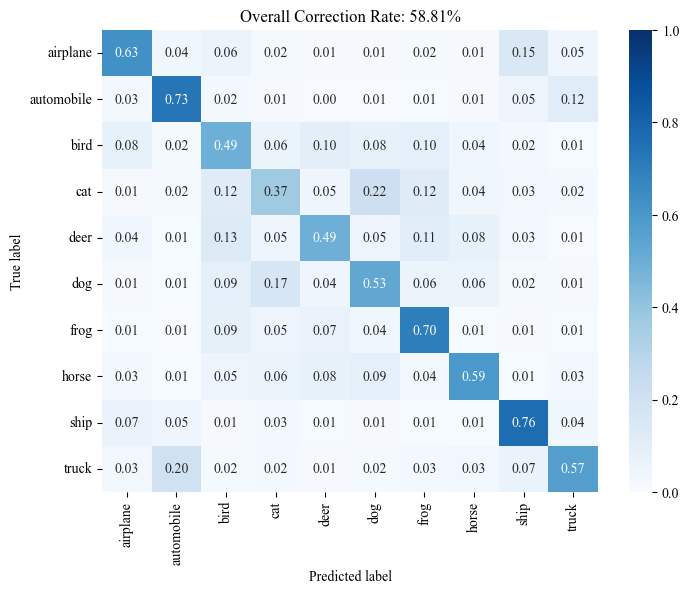

1:8 5th Epoch: 19/20

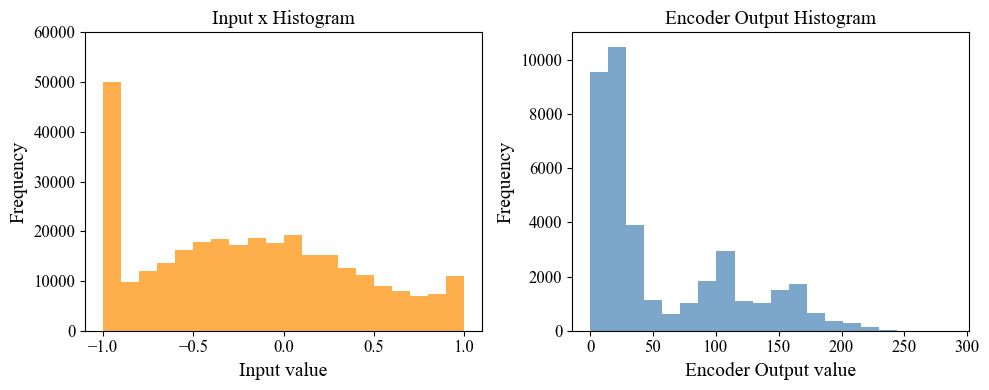

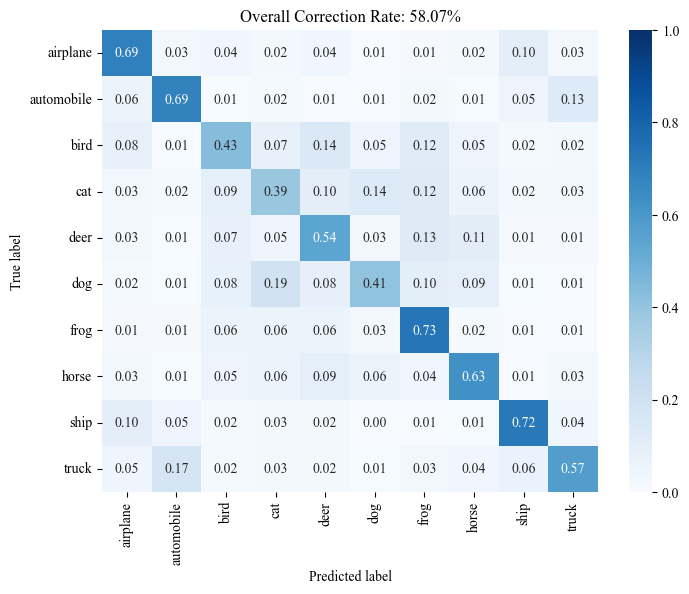

           Average  Best ID       Best  Worst ID      Worst
0   ACC  58.682000        3  59.380000         5  58.070000
1  LOSS   1.166861        3   1.139535         5   1.188885


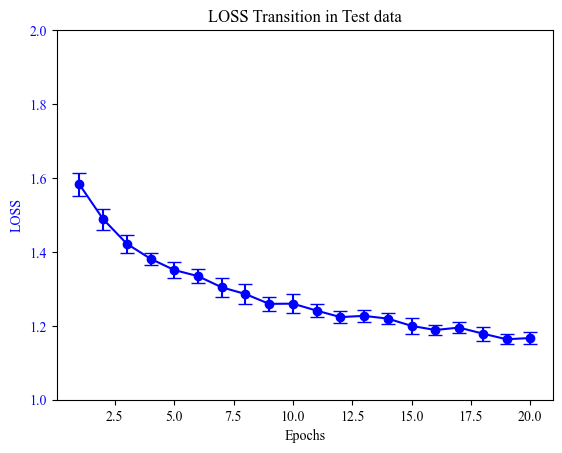

1:12 1th Epoch: 19/20

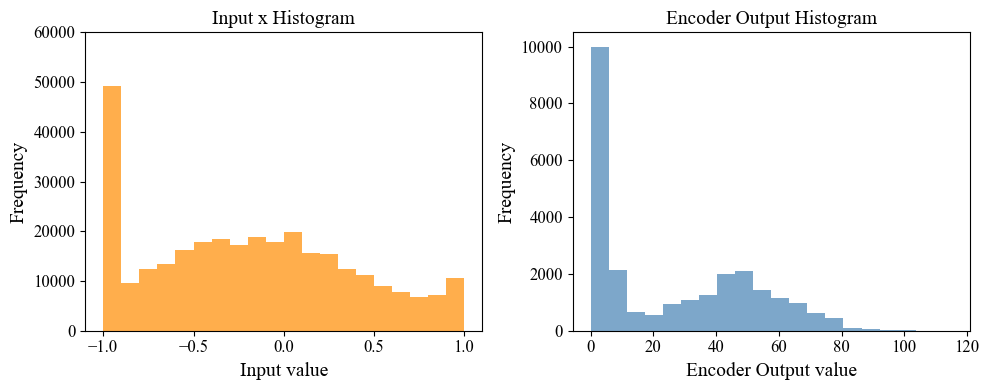

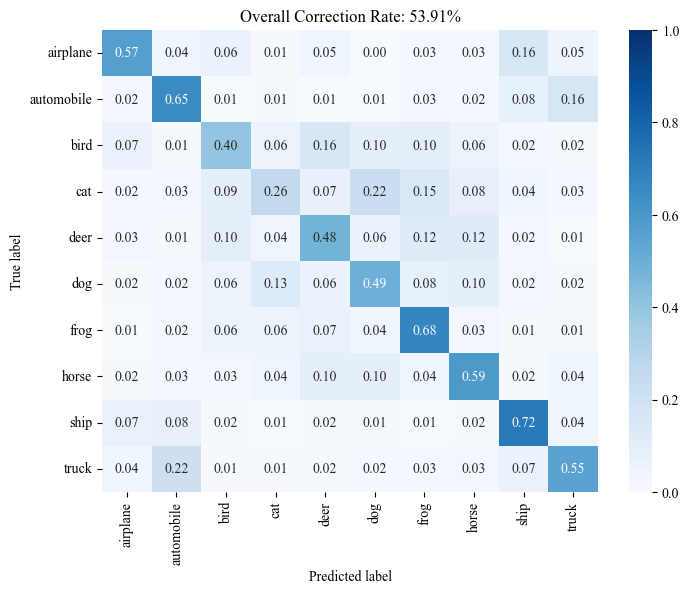

1:12 2th Epoch: 19/20

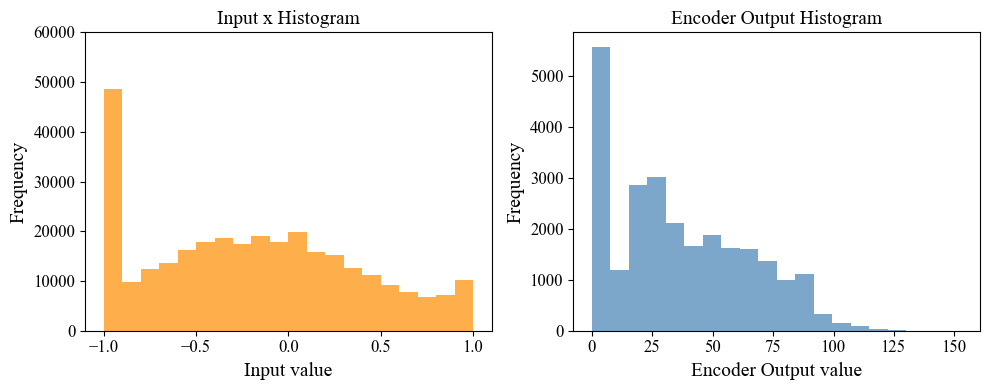

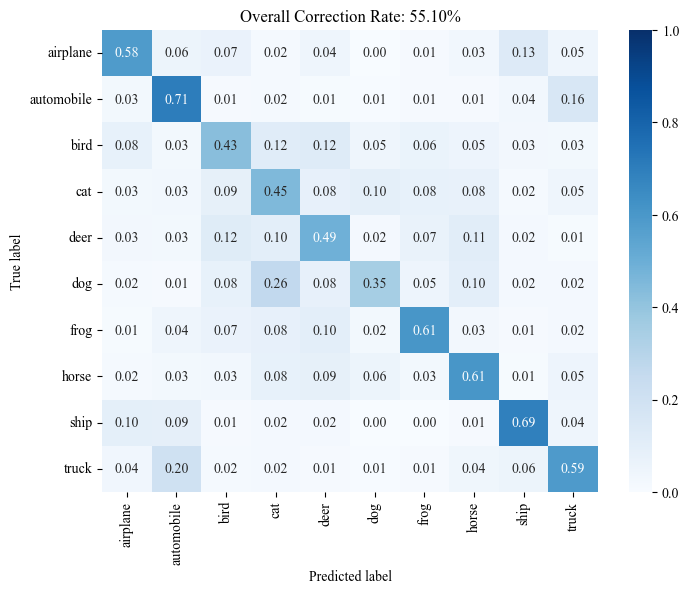

1:12 3th Epoch: 19/20

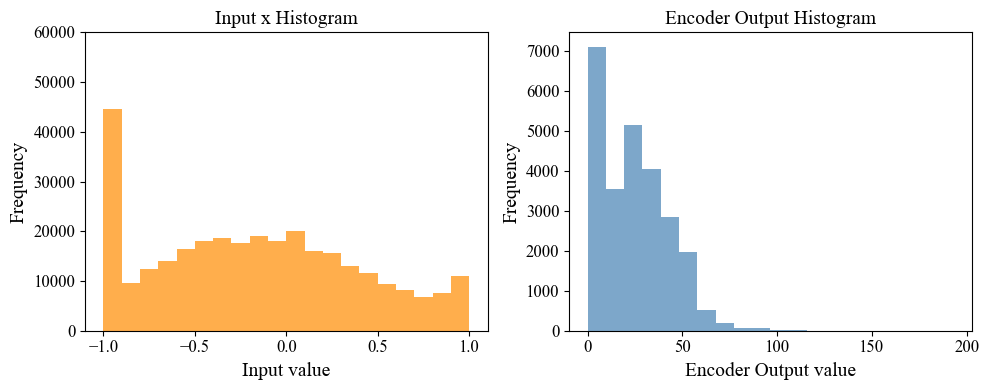

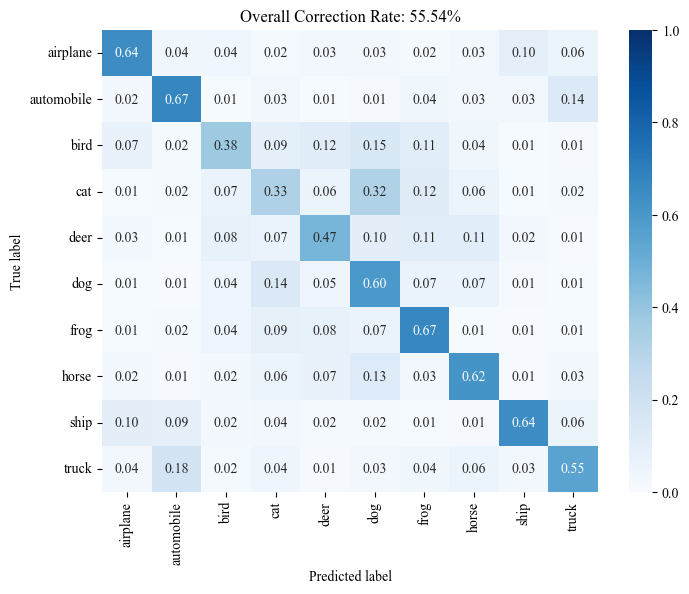

1:12 4th Epoch: 19/20

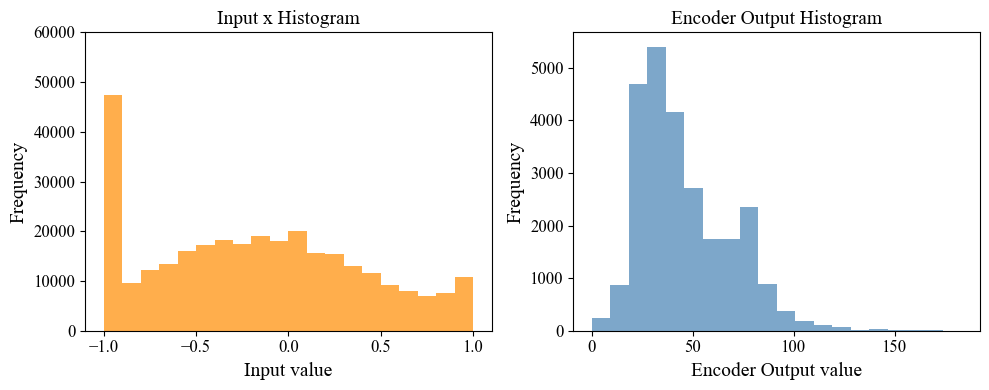

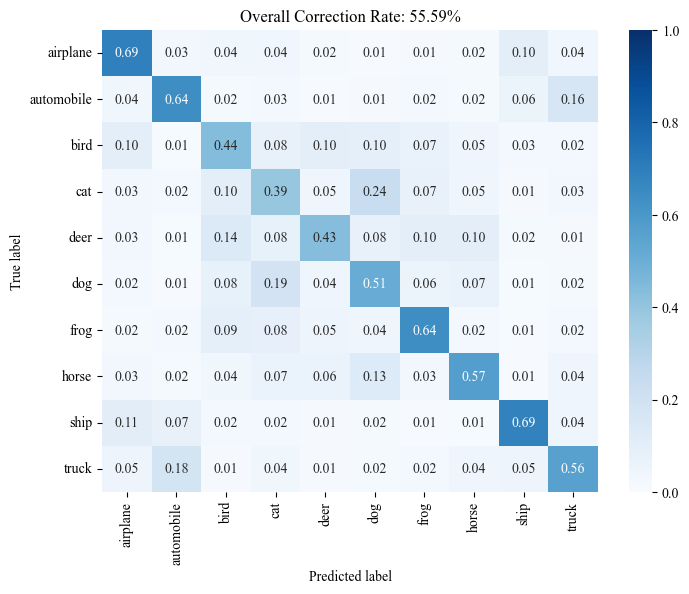

1:12 5th Epoch: 19/20

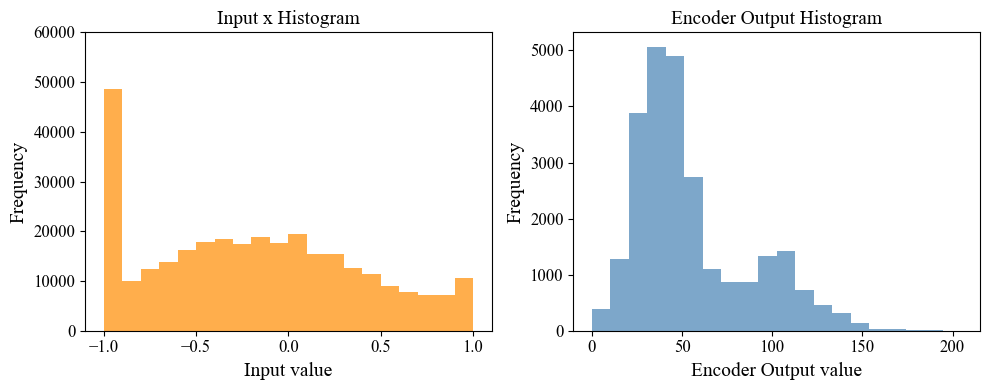

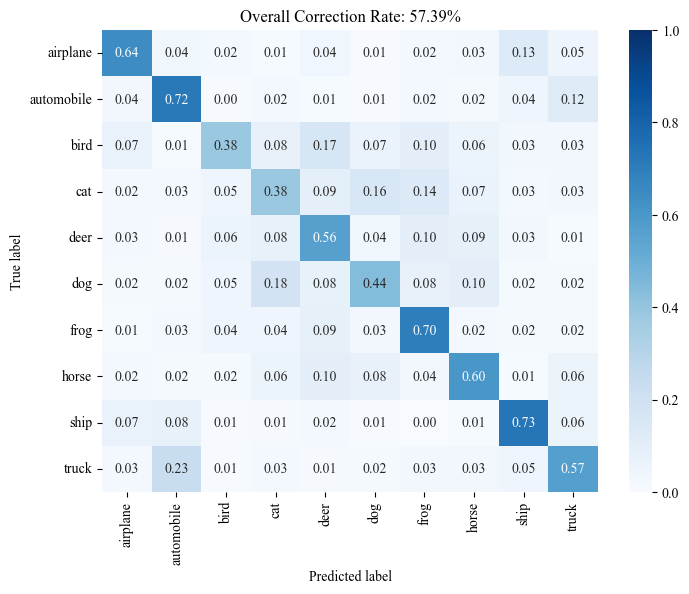

          Average  Best ID       Best  Worst ID      Worst
0   ACC  55.50600        5  57.390000         1  53.910000
1  LOSS   1.25061        5   1.214935         1   1.279198


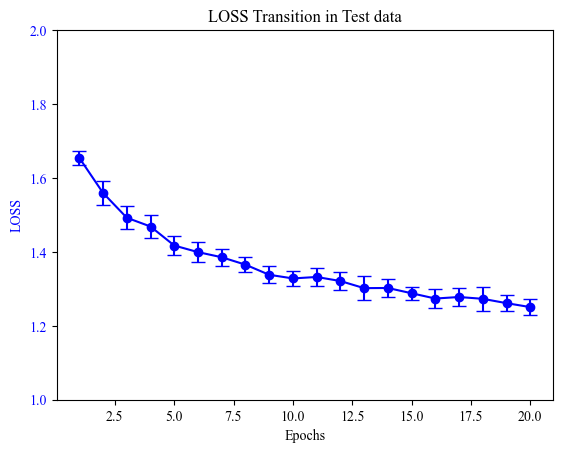

1:16 1th Epoch: 19/20

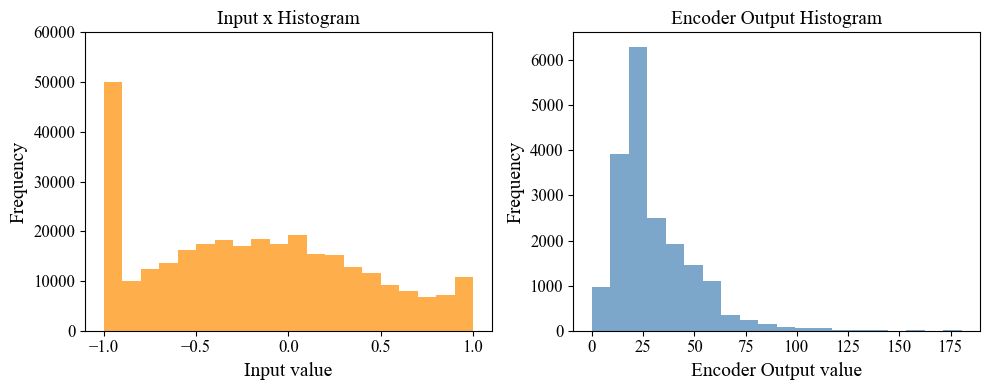

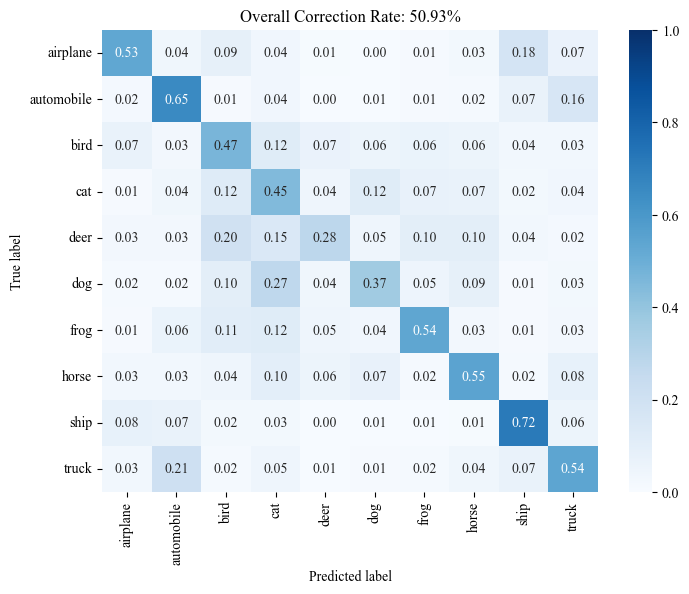

1:16 2th Epoch: 19/20

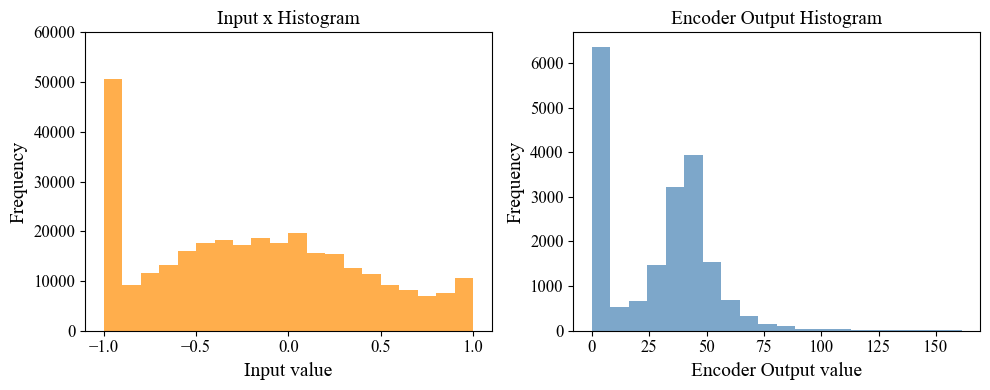

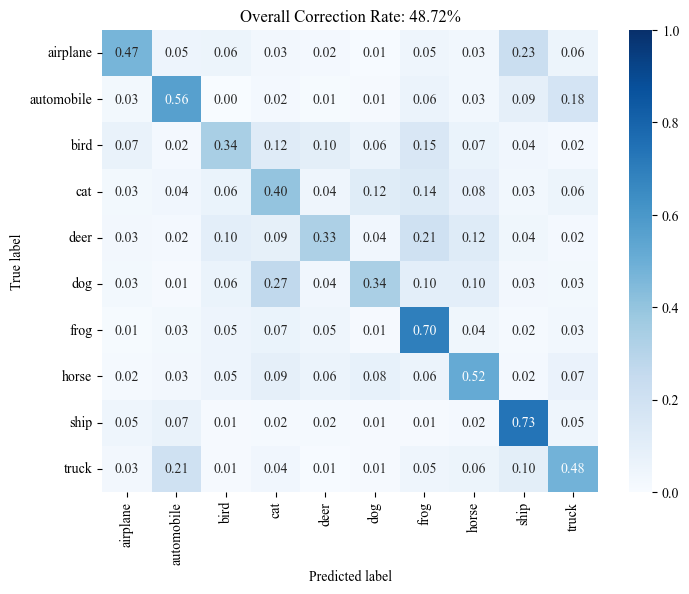

1:16 3th Epoch: 19/20

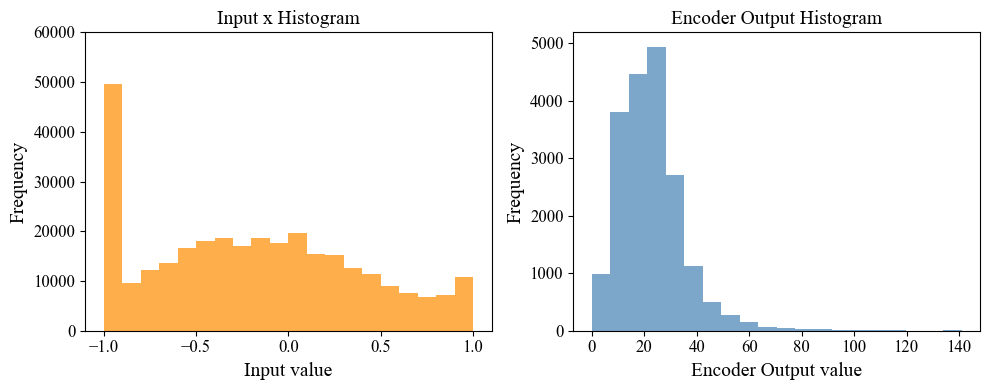

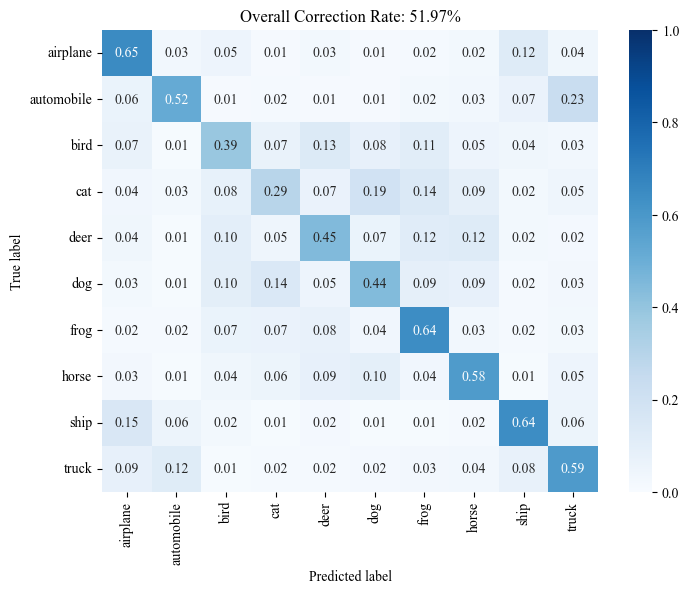

1:16 4th Epoch: 19/20

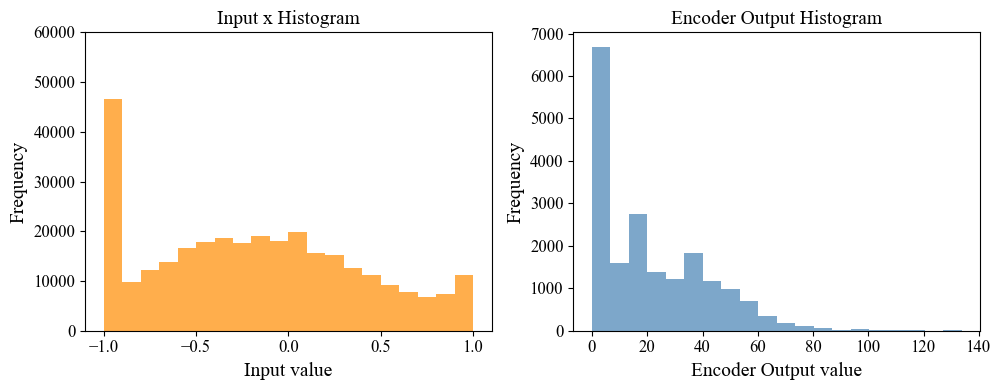

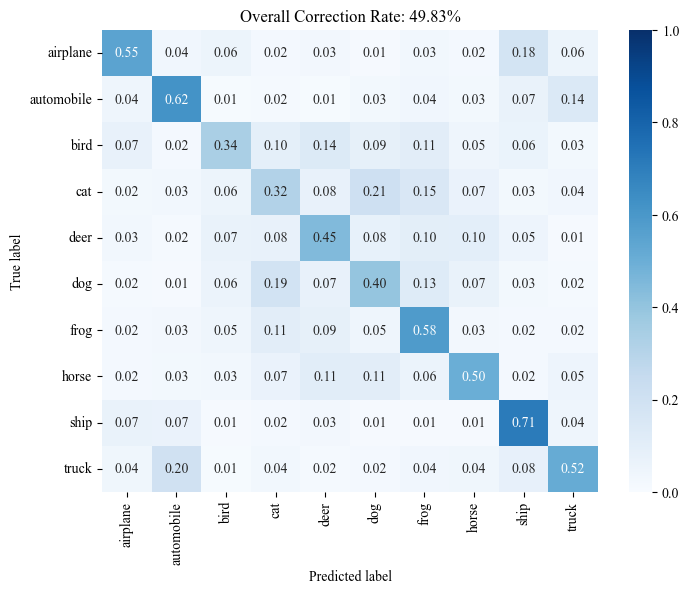

1:16 5th Epoch: 19/20

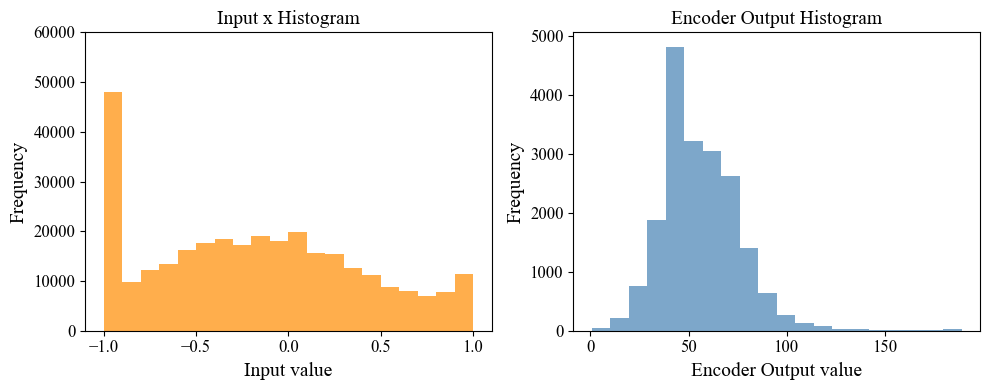

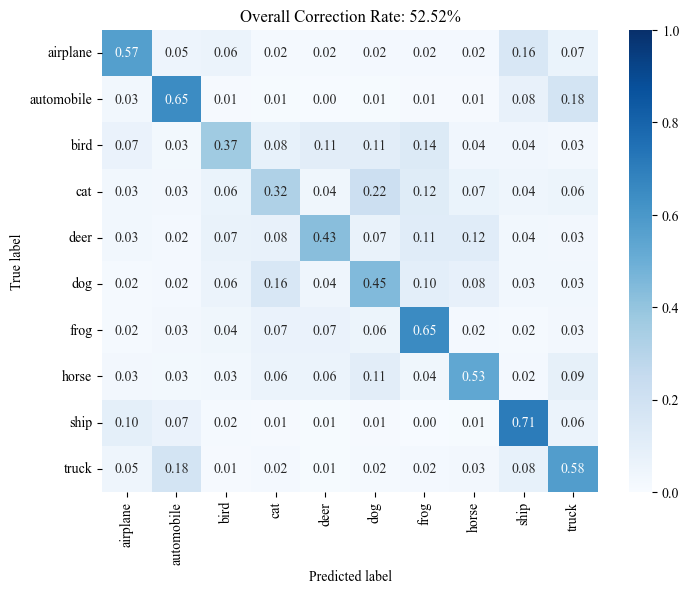

         Average  Best ID       Best  Worst ID      Worst
0   ACC  50.7940        5  52.520000         2  48.720000
1  LOSS   1.3751        5   1.333075         2   1.427913


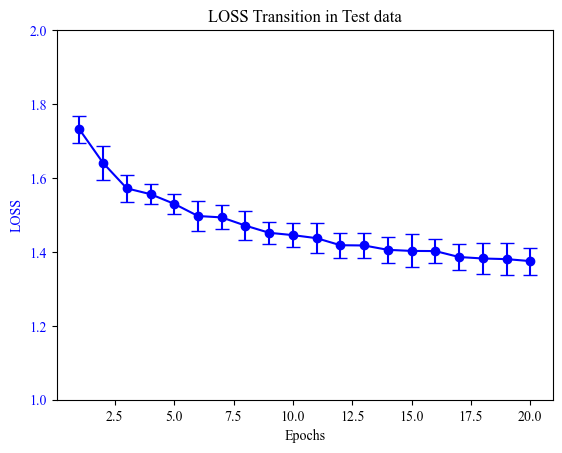

1:24 1th Epoch: 19/20

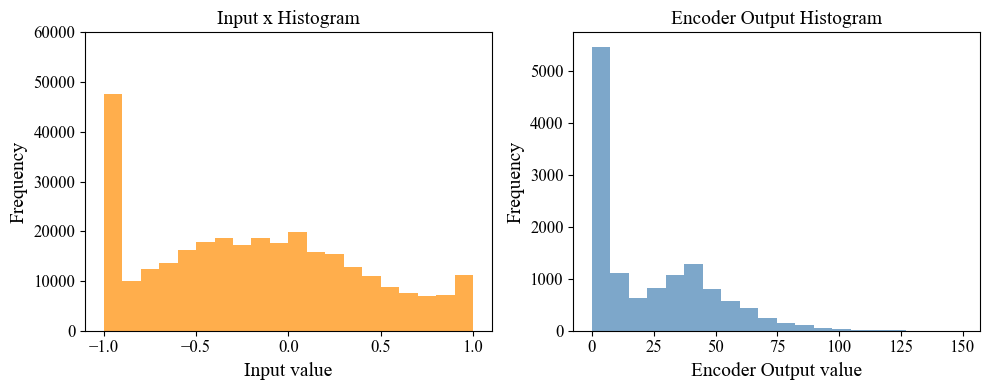

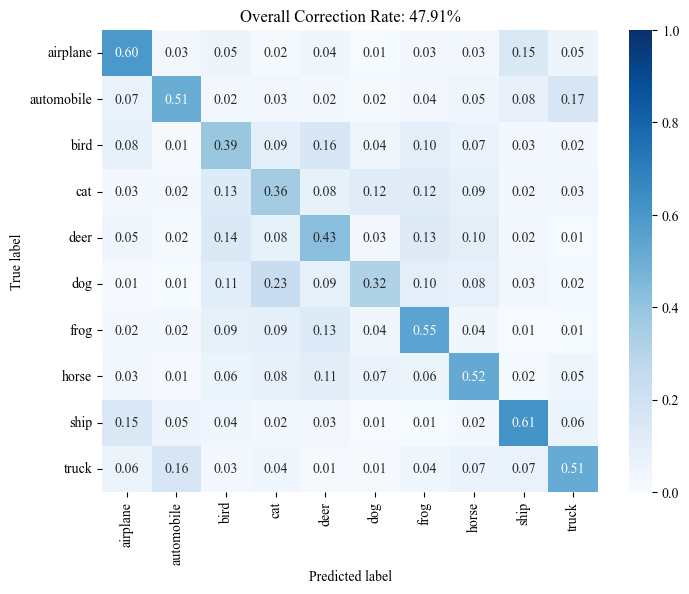

1:24 2th Epoch: 19/20

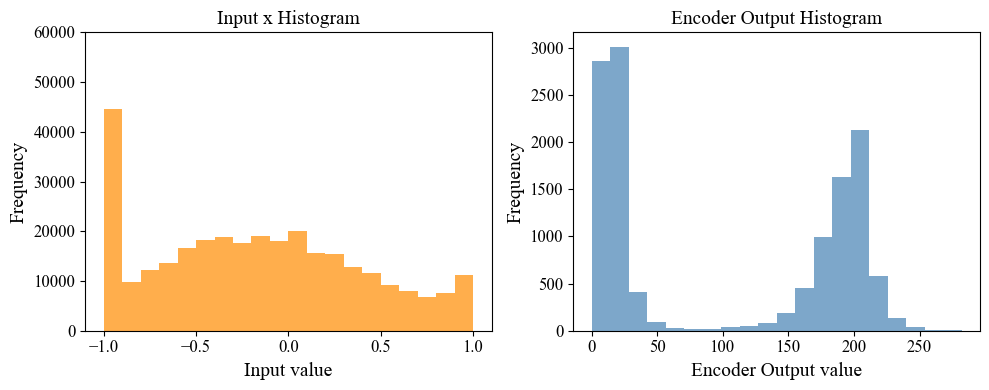

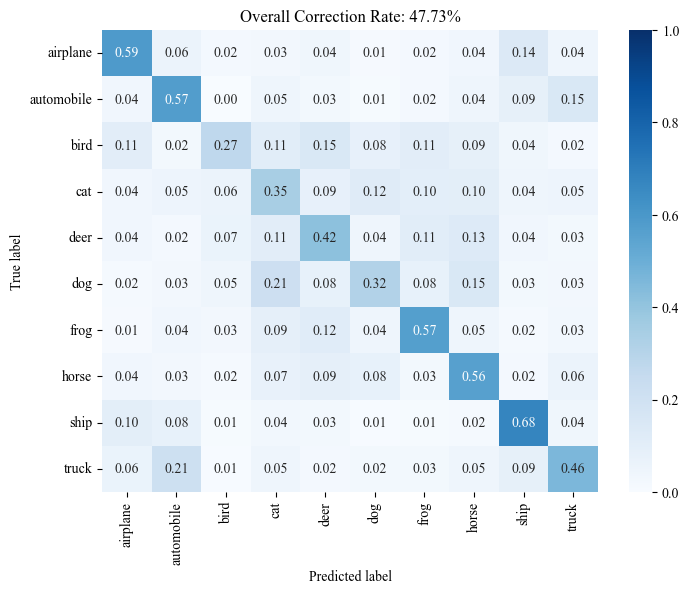

1:24 3th Epoch: 19/20

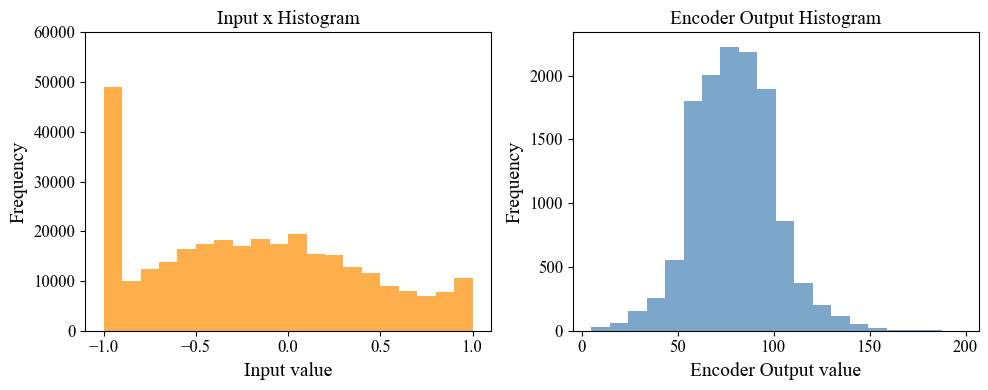

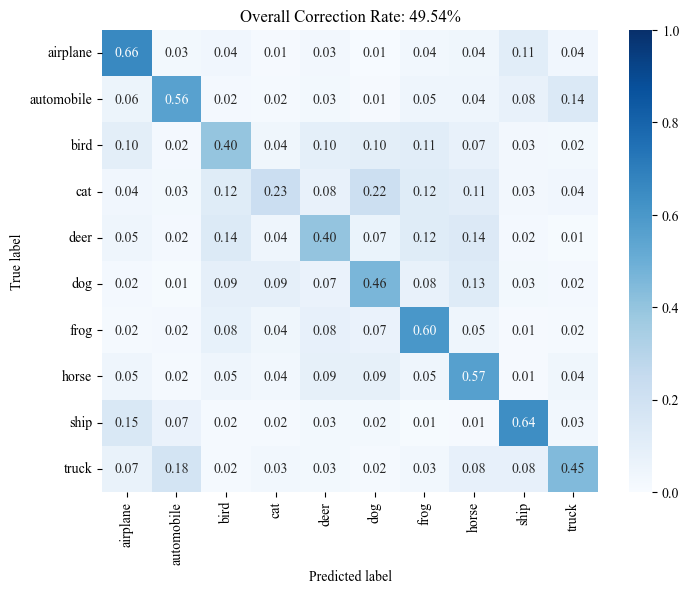

1:24 4th Epoch: 19/20

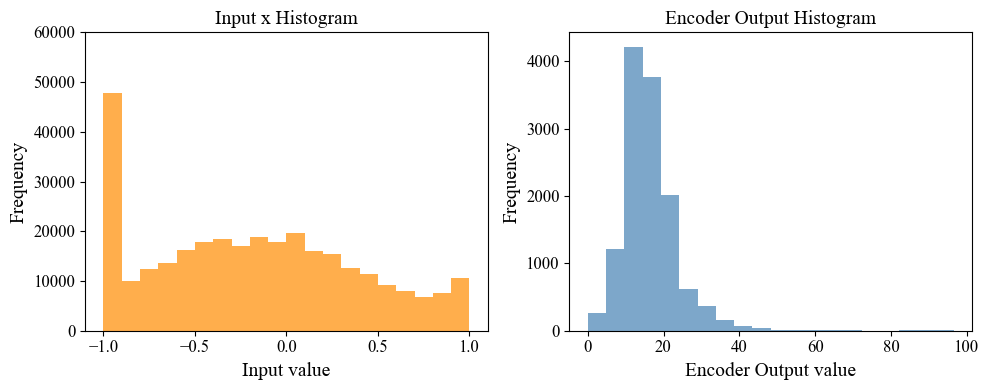

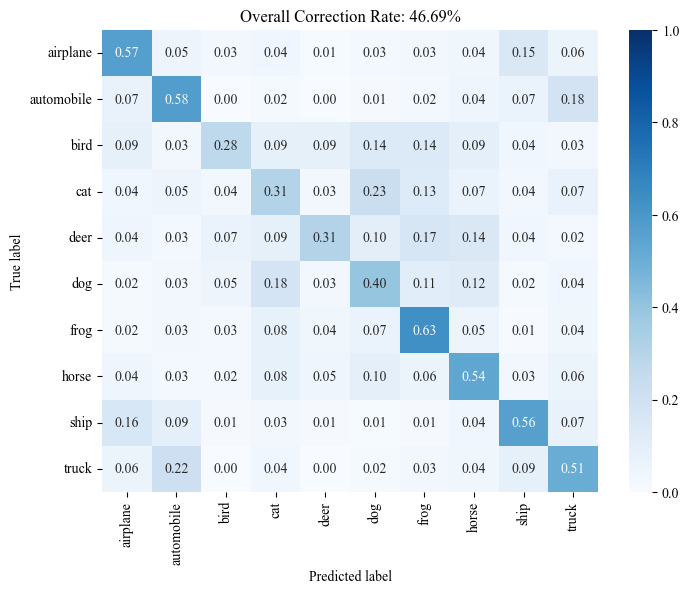

1:24 5th Epoch: 19/20

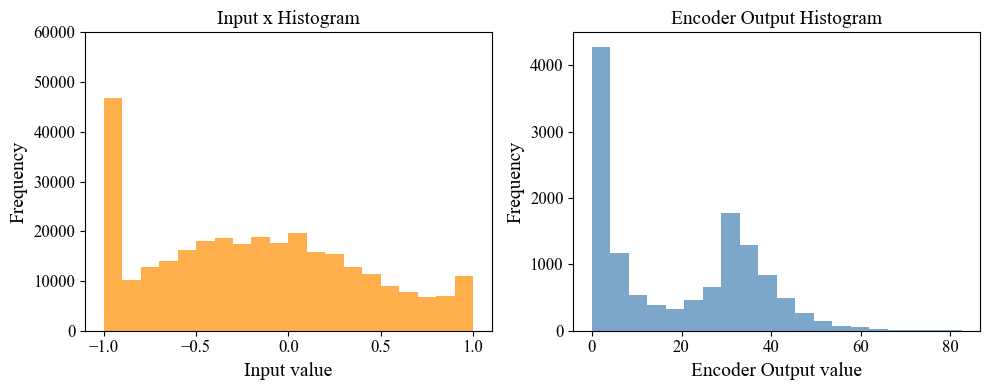

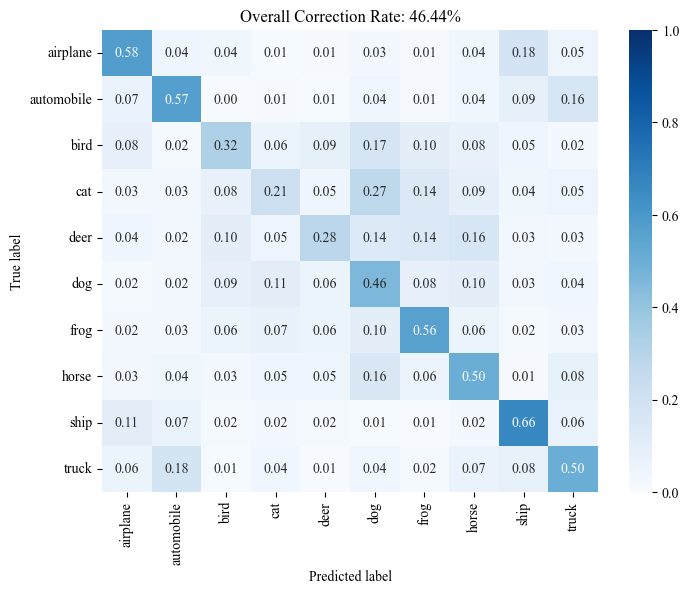

           Average  Best ID       Best  Worst ID      Worst
0   ACC  47.662000        3  49.540000         5  46.440000
1  LOSS   1.465471        3   1.419221         5   1.494881


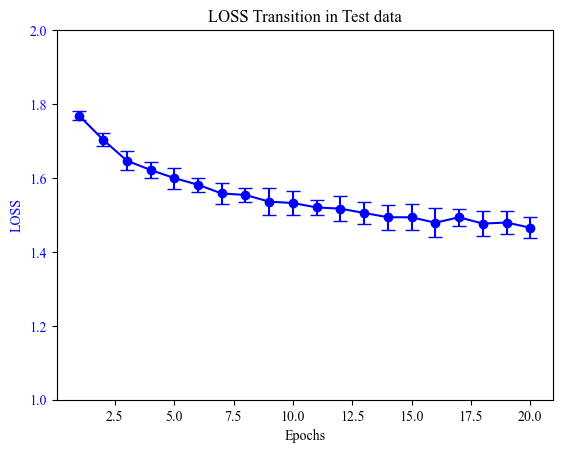

1:48 1th Epoch: 19/20

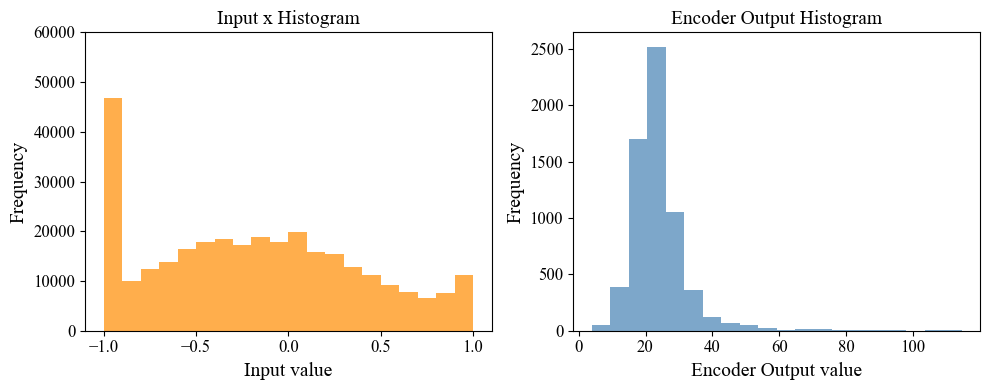

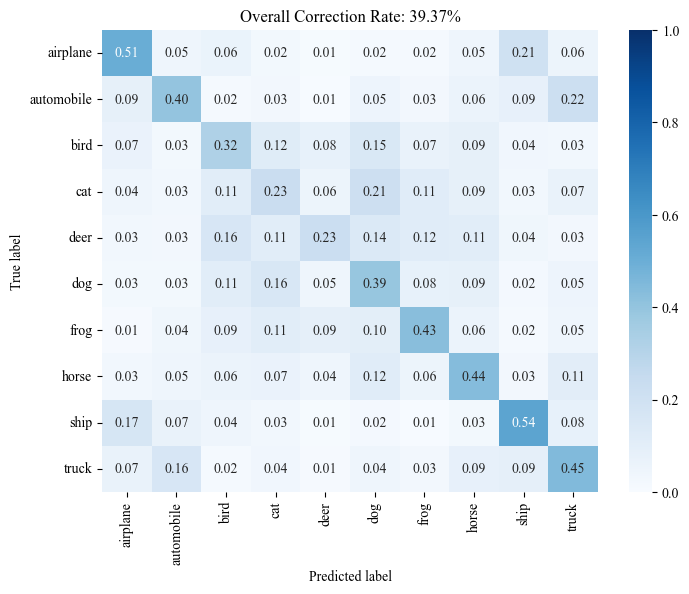

1:48 2th Epoch: 19/20

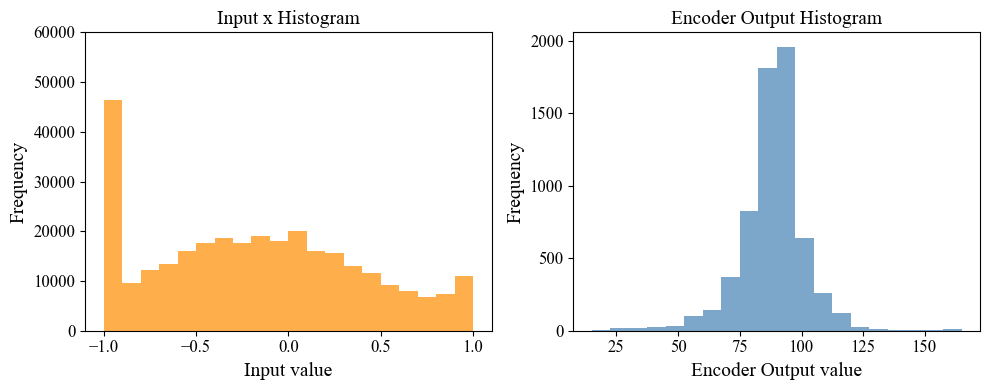

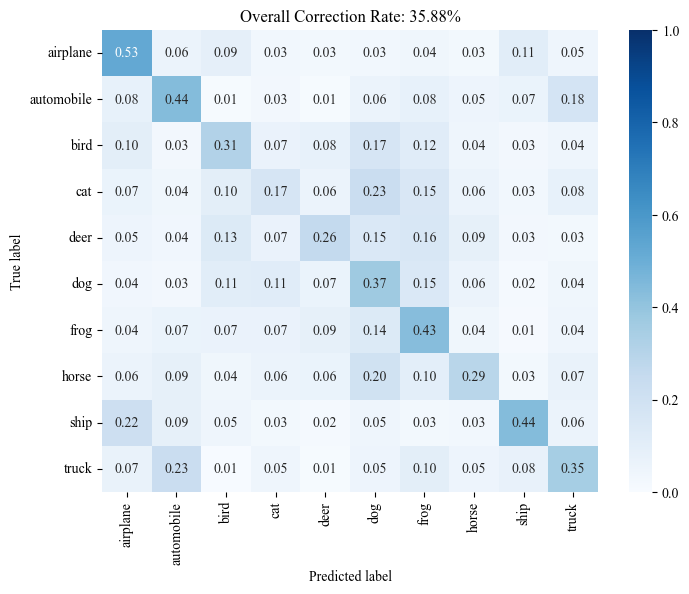

1:48 3th Epoch: 19/20

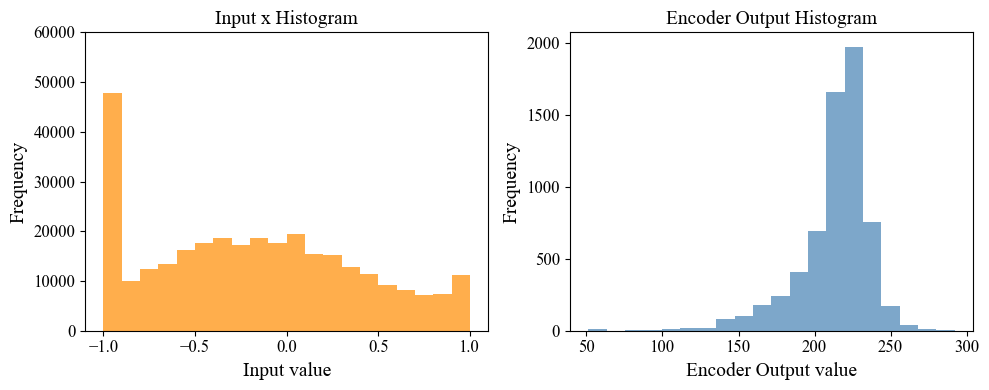

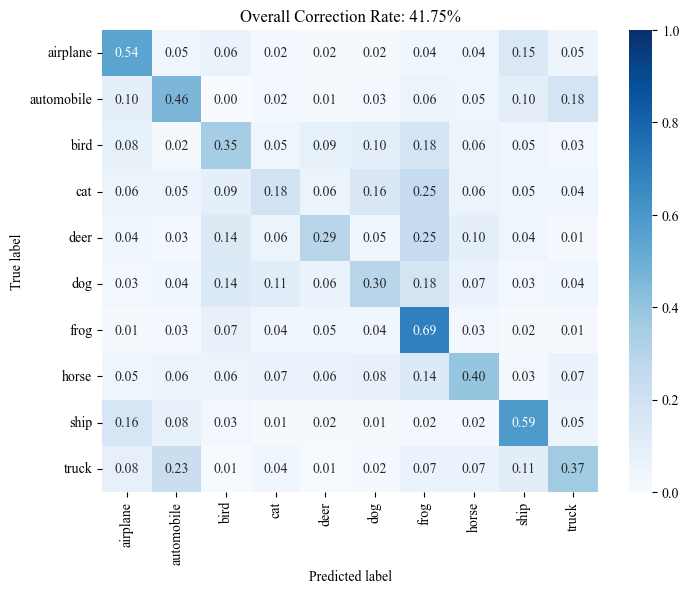

1:48 4th Epoch: 19/20

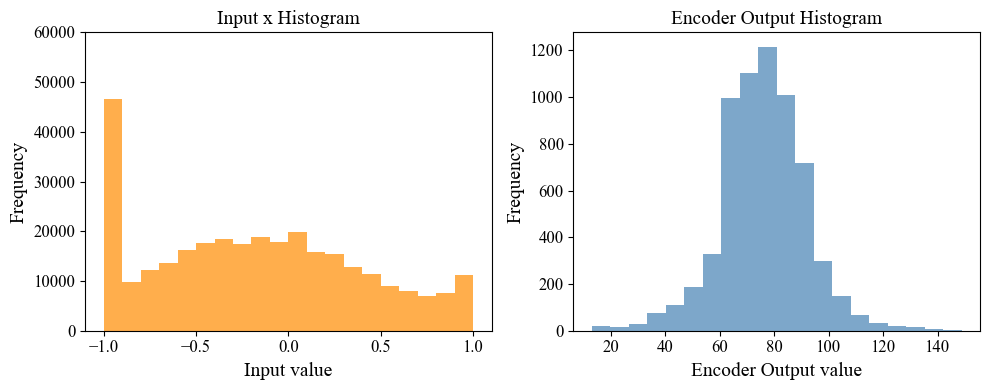

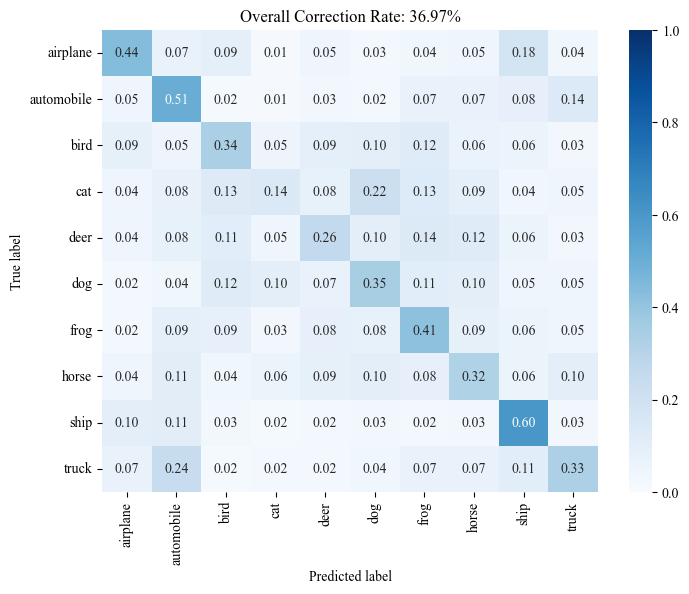

1:48 5th Epoch: 19/20

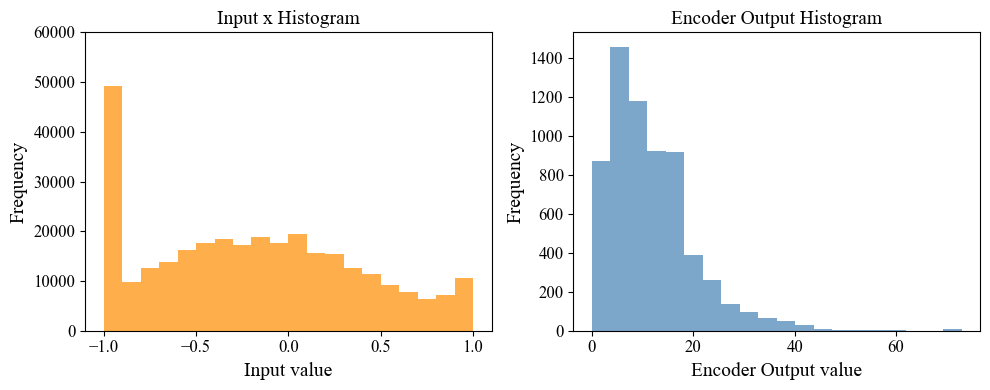

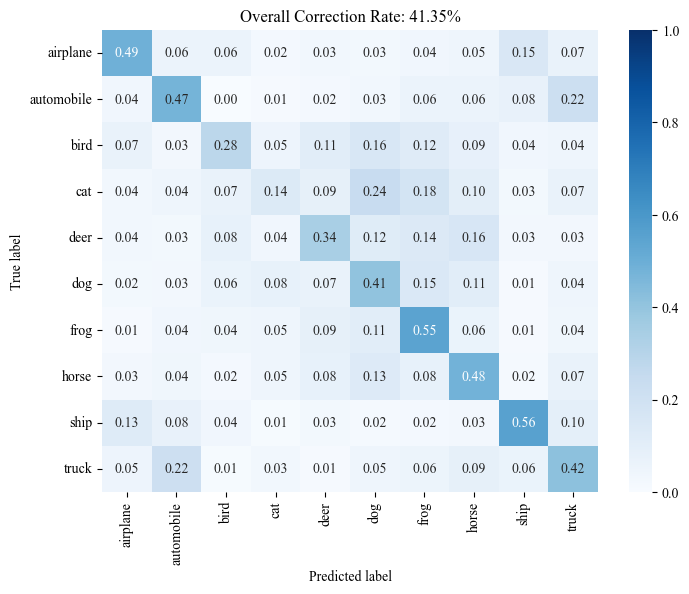

          Average  Best ID       Best  Worst ID      Worst
0   ACC  39.06400        3  41.750000         2  35.880000
1  LOSS   1.68931        3   1.624315         2   1.771778


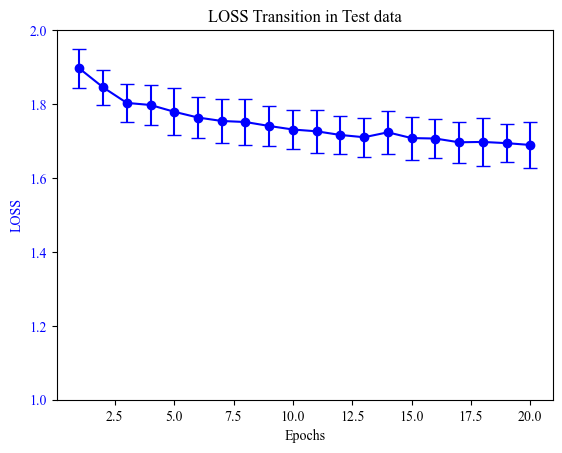

In [8]:
img_size = 32
channels = 3

DofIN = channels*img_size**2 ##CIFAR10 32*32*3
#leverage = 8 ##圧縮倍率
kernel_size = 4 #カーネルサイズ
max_epochs = 20#20

num_try = 5##5

leverages = [2,4,6,8,12,16,24,48]
results = []
All_last_LOSSs_ = []
All_last_ACCs_ = []
for leverage in leverages: 
    
    All_last_loss = []
    All_loss_test = []
    All_pro_time = []
    All_test_acc = []

    for num_times in range(1,num_try+1): 

        model = EncoderClassifier(img_size,channels, kernel_size, leverage).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        loss_train_ = []
        loss_test_ = []
        pro_time_ = []

                
        for epoch in range(max_epochs):

            sys.stderr.write('\r1:%d %dth Epoch: %d/%d' % (leverage,num_times, epoch, max_epochs)) 
            sys.stderr.flush()

            loss_train = 0
            loss_test = 0

            start_time1 = time.time()
            for (x,t) in train_dataloader:
                    
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                loss = criterion(y, t) 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_train += loss.item()
        
            loss_train_avg = loss_train / len(train_dataloader)
            end_time1 = time.time()
            pro_time_.append(end_time1-start_time1)


            model.eval()
            with torch.no_grad():
                all_preds = []
                all_labels = []
                correct = 0
                total = 0
                first_batch = True
                for x, t in test_dataloader:
                    x, t = x.to(device), t.to(device)
                    y = model(x).to(device)
                    _, predicted = torch.max(y, 1)
                    loss = criterion(y,t)
                    loss_test += loss.item()        
                    total += t.size(0)
                    correct += (predicted == t).sum().item()
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(t.cpu().numpy()) 
                    if epoch == max_epochs - 1:
                        if first_batch:
                            x_splitted = model.split(x, kernel_size)
                            x_in_flat = x_splitted.reshape(-1).detach().cpu().numpy()
                            x_encoded, _ = model.encoder(x_splitted)
                            x_out_flat = x_encoded.reshape(-1).detach().cpu().numpy()

                            # サブプロットで横に並べて表示
                            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

                            # 入力ヒストグラム
                            axes[0].hist(x_in_flat, bins=20, color='darkorange', alpha=0.7)
                            axes[0].set_xlabel("Input value", fontsize=14)
                            axes[0].set_ylabel("Frequency", fontsize=14)
                            axes[0].set_title("Input x Histogram", fontsize=14)
                            axes[0].tick_params(labelsize=12)
                            axes[0].set_ylim(0,60000)

                            # エンコーダ出力ヒストグラム
                            axes[1].hist(x_out_flat, bins=20, color='steelblue', alpha=0.7)
                            axes[1].set_xlabel("Encoder Output value", fontsize=14)
                            axes[1].set_ylabel("Frequency", fontsize=14)
                            axes[1].set_title("Encoder Output Histogram", fontsize=14)
                            axes[1].tick_params(labelsize=12)

                            plt.tight_layout()
                            plt.show()

                            first_batch = False
            
            #print(f"Test Accuracy: {100 * correct / total:.2f}%")
            loss_test_avg = loss_test / len(test_dataloader)

            loss_train_.append(loss_train_avg)
            loss_test_.append(loss_test_avg)
            #if epoch == max_epochs-1:
        All_loss_test.append(loss_test_)
        All_pro_time.append(sum(pro_time_)) 

        cm = confusion_matrix(all_labels, all_preds)
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 正規化（行ごとに割合に）

        Last_loss_test = loss_test_[-1]
        All_last_loss.append(Last_loss_test)
        Test_acc = 100 * correct / total
        All_test_acc.append(Test_acc)
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck']
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names,vmin=0.0, vmax=1.0)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title(f"Overall Correction Rate: {Test_acc:.2f}%")
        plt.show()

    All_last_LOSSs_.append(All_last_loss)
    All_last_ACCs_.append(All_test_acc)
    
    ACC_mean = np.mean(All_test_acc)
    ACC_best = np.max(All_test_acc)
    ACC_bestID = np.argmax(All_test_acc)+1
    ACC_worst = np.min(All_test_acc)
    ACC_worstID = np.argmin(All_test_acc)+1

    LOSS_mean = np.mean(All_last_loss)
    LOSS_best = np.min(All_last_loss)
    LOSS_bestID = np.argmin(All_last_loss)+1
    LOSS_worst = np.max(All_last_loss)
    LOSS_worstID = np.argmax(All_last_loss)+1

    data = {
            "": ["ACC", "LOSS"],
        "Average": [ACC_mean, LOSS_mean],
        "Best ID": [ACC_bestID, LOSS_bestID],
        "Best": [ACC_best, LOSS_best],
        "Worst ID": [ACC_worstID, LOSS_worstID],
        "Worst": [ACC_worst, LOSS_worst],
    }

    df = pd.DataFrame(data)
    results.append(data)
    print(df)
    epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
    num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

    # 各エポックごとに平均と標準偏差を計算
    mean_loss = np.mean(All_loss_test, axis=0)
    std_loss = np.std(All_loss_test, axis=0)

    # グラフの描画
    fig, ax1 = plt.subplots()

    # 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
    ax1.errorbar(
        x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
        fmt='-o', color='blue', ecolor='blue', capsize=5, 
    )

    # 軸ラベルやタイトルの設定
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    plt.title('LOSS Transition in Test data')
    plt.ylim(1.0,2.0)
    plt.show()


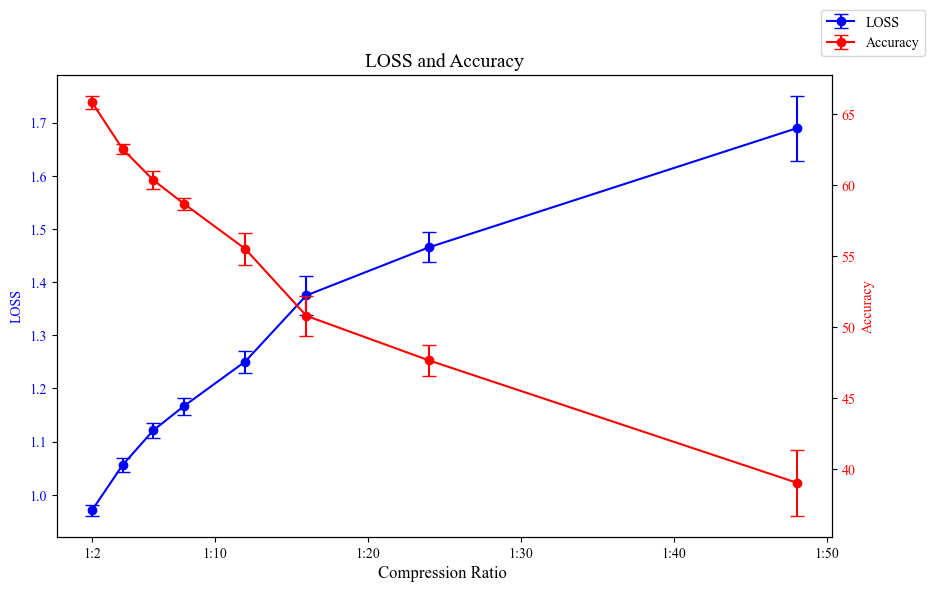

In [9]:
# 横軸の値 (1/leverage)
x_values = [leverage for leverage in leverages]
memory_lis =[2,10,20,30,40,50]

# LOSS用の平均値と標準偏差を計算
loss_means = [np.mean(loss_list) for loss_list in All_last_LOSSs_]
loss_stds = [np.std(loss_list) for loss_list in All_last_LOSSs_]

# ACC用の平均値と標準偏差を計算
acc_means = [np.mean(acc_list) for acc_list in All_last_ACCs_]
acc_stds = [np.std(acc_list) for acc_list in All_last_ACCs_]

# グラフの描画
fig, ax1 = plt.subplots(figsize=(10, 6))

# MSEのエラーバー付き折れ線グラフ
ax1.errorbar(
    x=x_values, y=loss_means, yerr=loss_stds,
    fmt='-o', color='blue', ecolor='blue', capsize=5, label='LOSS'
)
ax1.set_ylabel('LOSS', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
# SSIMのエラーバー付き折れ線グラフ
ax2.errorbar(
    x=x_values, y=acc_means, yerr=acc_stds,
    fmt='-o', color='red', ecolor='red', capsize=5, label='Accuracy'
)
ax2.set_ylabel('Accuracy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 軸ラベルとスケールの設定
ax1.set_xlabel('Compression Ratio ', fontsize=12)

ax1.set_xticks(memory_lis)
ax1.set_xticklabels([f"1:{x}" for x in memory_lis]) # ラベルを「1:N」形式で表示

# タイトルと凡例
plt.title('LOSS and Accuracy', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2, labels1 + labels2, loc="upper right", bbox_to_anchor=(1, 1)
)
plt.show()

In [10]:
all_data = pd.concat([pd.DataFrame(result) for result in results], ignore_index=True)
print(all_data)

            Average  Best ID       Best  Worst ID      Worst
0    ACC  65.810000        5  66.390000         1  65.000000
1   LOSS   0.970911        4   0.957044         1   0.984614
2    ACC  62.524000        5  62.900000         4  62.110000
3   LOSS   1.056126        5   1.037296         3   1.075532
4    ACC  60.342000        4  61.090000         5  59.430000
5   LOSS   1.121147        4   1.109383         5   1.149001
6    ACC  58.682000        3  59.380000         5  58.070000
7   LOSS   1.166861        3   1.139535         5   1.188885
8    ACC  55.506000        5  57.390000         1  53.910000
9   LOSS   1.250610        5   1.214935         1   1.279198
10   ACC  50.794000        5  52.520000         2  48.720000
11  LOSS   1.375100        5   1.333075         2   1.427913
12   ACC  47.662000        3  49.540000         5  46.440000
13  LOSS   1.465471        3   1.419221         5   1.494881
14   ACC  39.064000        3  41.750000         2  35.880000
15  LOSS   1.689310     

In [11]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_Classifer', 'data','texts')  
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'CNN_VCR_PM_Class01_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_last_LOSSs_)
    writer.writerow(All_last_ACCs_)

C:\Users\Scent\OneDrive\CODES\konishi_Classifer\data\texts
